In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pims
from pims import Frame
import scipy
from scipy import optimize
import time

In [2]:
def openFiles(path):
    
    times = []
    spinPts = []
    spinLs = []
    spinLsC = []
    arcLs = []
    curves = []
    RSs = []
    neIAvg = []
    neIMed = []
    neIAvg0 = []
    neIMed0 = []
    pix = []
    neAvgs = []
    neSubAvgs = []
    
    for files in os.scandir(path):
        
        data = open(files, 'r')
        blanks = 0
        timesI = []
        spinPtsI = []
        spinLsI = []
        spinLsCI = []
        arcLsI = []
        curvesI = []
        RSsI = []
        neIAvgI = []
        neIMedI = []
        neIAvg0I = []
        neIMed0I = []
        pixI = []
        neAvgsI = []
        neSubAvgsI = []
        
        for line in data.readlines():
            
            iData = line.split()
            iData0 = iData[0].strip('[],')
            valueWorks = True
            
            if iData0 != '':
                try:
                    float(iData0)
                except:
                    valueWorks = False
            
            if valueWorks == True:
                if blanks == 1:
                    timesI.append(float(iData[0])/60)
                elif blanks == 2:
                    for j in range(len(iData)):
                        value = int(round(float(iData[j].strip('[],'))))
                        if j % 2 == 1:
                            spinPtsI.append([int(round(float(iData[j-1].strip('[],')))), value])
                elif blanks == 3:
                    spinLsI.append(float(iData[0]))
                elif blanks == 4:
                    spinLsCI.append(float(iData[0]))
                elif blanks == 5:
                    arcLsI.append(float(iData[0]))
                elif blanks == 6:
                    curvesI.append(float(iData[0]))
                elif blanks == 7:
                    RSsI.append(float(iData[0]))
                elif blanks == 8:
                    neIAvgI.append(float(iData[0]))
                elif blanks == 9:
                    neIMedI.append(float(iData[0]))
                elif blanks == 10:
                    neIAvg0I.append(float(iData[0]))
                elif blanks == 11:
                    neIMed0I.append(float(iData[0]))
                elif blanks == 12:
                    pixI.append(int(iData[0]))
                elif blanks == 13:
                    neAvgsI.append(float(iData[0]))
                elif blanks == 14:
                    neSubAvgsI.append(float(iData[0]))
            else:
                blanks += 1
        
        times.append(timesI)
        spinPts.append(spinPtsI)
        spinLs.append(spinLsI)
        spinLsC.append(spinLsCI)
        arcLs.append(arcLsI)
        curves.append(curvesI)
        RSs.append(RSsI)
        neIAvg.append(neIAvgI)
        neIMed.append(neIMedI)
        neIAvg0.append(neIAvg0I)
        neIMed0.append(neIMed0I)
        pix.append(pixI)
        neAvgs.append(neAvgsI)
        neSubAvgs.append(neSubAvgsI)
    
    return(times, spinPts, spinLs, spinLsC, arcLs, curves, RSs, neIAvg, neIMed, neIAvg0, neIMed0, pix, neAvgs, neSubAvgs)




def smoothCurve(curves, RSs, order):
    
    smoothCs = []
    smoothRSs = []
    count = 0
    
    initCs = []
    initRSs = []
    for i in range(len(curves)):
        initCs.append(curves[i])
        initRSs.append(RSs[i])
    
    while count < order:
        
        tempCs = []
        tempRSs = []
        
        tempCs.append((4*initCs[0]+2*initCs[1]+initCs[2])/7)
        tempCs.append((2*initCs[0]+4*initCs[1]+2*initCs[2]+initCs[3])/9)
        tempRSs.append((4*initRSs[0]+2*initRSs[1]+initRSs[2])/7)
        tempRSs.append((2*initRSs[0]+4*initRSs[1]+2*initRSs[2]+initRSs[3])/9)
        
        for i in range(2, len(initCs)-2):
            tempCs.append((initCs[i-2]+2*initCs[i-1]+4*initCs[i]+2*initCs[i+1]+initCs[i+2])/10)
            tempRSs.append((initRSs[i-2]+2*initRSs[i-1]+4*initRSs[i]+2*initRSs[i+1]+initRSs[i+2])/10)
        
        tempCs.append((2*initCs[len(initCs)-4]+4*initCs[len(initCs)-3]+2*initCs[len(initCs)-2]+initCs[len(initCs)-1])/9)
        tempCs.append((4*initCs[len(initCs)-3]+2*initCs[len(initCs)-2]+initCs[len(initCs)-1])/7)
        tempRSs.append((2*initRSs[len(initRSs)-4]+4*initRSs[len(initRSs)-3]+2*initRSs[len(initRSs)-2]+initRSs[len(initRSs)-1])/9)
        tempRSs.append((4*initRSs[len(initRSs)-3]+2*initRSs[len(initRSs)-2]+initRSs[len(initRSs)-1])/7)
        
        initCs = []
        initRSs = []
        for i in range(len(tempCs)):
            initCs.append(tempCs[i])
            initRSs.append(RSs[i])
        
        count += 1
    
    for i in range(len(tempCs)):
        smoothCs.append(tempCs[i])
        smoothRSs.append(tempRSs[i])
    
    return(smoothCs, smoothRSs)




def sigmoid(times, curves):
    
    fits = []
    fitCs = []
    fitCovs = []
    taus = []
    t0s = []
    
    for i in range(len(times)):
        
        time = times[i]
        curve = curves[i]
        def f(x, a, b, c, d):
            return(a/(1+np.exp(-b*(x-c)))+d)
        p0 = [np.amax(curve), 1, 10, np.amin(curve)]
        
        fitCoeffs, fitCov = scipy.optimize.curve_fit(f, time, curve, p0, maxfev=1000000)
        
        fit = []
        for j in range(len(time)):
            fit.append(fitCoeffs[0]/(1+np.exp(-fitCoeffs[1]*(time[j]-fitCoeffs[2])))+fitCoeffs[3])
        
        fits.append(fit)
        fitCs.append(fitCoeffs)
        fitCovs.append(fitCov)
        taus.append(fitCoeffs[1])
        t0s.append(fitCoeffs[2])
    
    return(fits, fitCs, fitCovs, taus, t0s)




def neighbor(imagesR, frameRate, endStart, startEnd):
    
    refTs = []
    refIs = []
    refTsPre = []
    refIsPre = []
    refTsPost = []
    refIsPost = []
    
    for i in range(len(imagesR)):
        refIm = imagesR[i]
        Is = []
        for j in range(len(refIm)):
            for k in range(len(refIm[0])):
                Is.append(refIm[j][k])
        refTs.append(i*frameRate)
        refIs.append(np.mean(Is))
    
    for i in range(endStart):
        refIm = imagesR[i]
        preIs = []
        for j in range(len(refIm)):
            for k in range(len(refIm[0])):
                preIs.append(refIm[j][k])
        refTsPre.append(i*frameRate)
        refIsPre.append(np.mean(preIs))
    
    for i in range(len(imagesR)-startEnd-1):
        refIm = imagesR[i+startEnd]
        postIs = []
        for j in range(len(refIm)):
            for k in range(len(refIm[0])):
                postIs.append(refIm[j][k])
        refTsPost.append((i+startEnd)*frameRate)
        refIsPost.append(np.mean(postIs))
    
    return(refTs, refIs, refTsPre, refIsPre, refTsPost, refIsPost)




def postAblationTime(times, frameRate, startFrame):
    
    pAbTs = []
    addFactor = frameRate*startFrame
    for i in range(len(times)):
        pAbTs.append(times[i]+addFactor)
    
    return(pAbTs)




def openIms(imsPath):
    
    images = []
    for files in os.listdir(imsPath):
        images.append(pims.open(os.path.join(imsPath, files)))
    
    return(images)




def fitCoefficientN(imagesC, imagesN, imagesB, startFrames, frameRates):
    
    times = []
    for i in range(len(frameRates)):
        timesI = []
        for n in range(len(imagesB[i])-startFrames[i]-1):
            if n != 0:
                timesI.append(n*frameRates[i])
        times.append(timesI)
    
    backIs = []
    backIsT = []
    for i in range(len(frameRates)):
        backIsI = []
        backIsTsI = []
        imagesBi = imagesB[i]
        for n in range(len(imagesBi)-startFrames[i]-1):
            if n != 0:
                imageB = imagesBi[n+startFrames[i]]
                IsN = []
                for j in range(len(imageB)):
                    for k in range(len(imageB[0])):
                        IsN.append(imageB[j][k])
                        backIsTsI.append(imageB[j][k])
                backIsI.append(np.mean(IsN))
        backIs.append(backIsI)
        backIsT.append(np.mean(backIsTsI))
    
    cytoIs = []
    for i in range(len(imagesC)):
        cytoIsI = []
        imagesCi = imagesC[i]
        for n in range(len(imagesCi)-startFrames[i]-1):
            if n != 0:
                imageC = imagesCi[n+startFrames[i]]
                IsN = []
                for j in range(len(imageC)):
                    for k in range(len(imageC[0])):
                        IsN.append(imageC[j][k])
                cytoIsI.append(np.mean(IsN))
        cytoIs.append(cytoIsI)
    
    nucIs = []
    for i in range(len(imagesN)):
        nucIsI = []
        imagesNi = imagesN[i]
        for n in range(len(imagesNi)-startFrames[i]-1):
            if n != 0:
                imageN = imagesNi[n+startFrames[i]]
                IsN = []
                for j in range(len(imageN)):
                    for k in range(len(imageN[0])):
                        IsN.append(imageN[j][k])
                nucIsI.append(np.mean(IsN))
        nucIs.append(nucIsI)
    
    Cs = []
    cCs = []
    nCs = []
    p = [1]
    for i in range(len(times)):
        timesI = times[i]
        cytoIsI = cytoIs[i]
        nucIsI = nucIs[i]
        backIsTI = backIsT[i]
        def fC(x, a):
            return((cytoIsI[0]-backIsTI)*np.exp(-a*x)+backIsTI)
        def fN(x, a):
            return((nucIsI[0]-backIsTI)*np.exp(-a*x)+backIsTI)
        cCi, fitCovC = scipy.optimize.curve_fit(fC, timesI, cytoIsI, p, maxfev=1000000)
        nCi, fitCovN = scipy.optimize.curve_fit(fN, timesI, nucIsI, p, maxfev=1000000)
        Cs.append(cCi[0])
        Cs.append(nCi[0])
        cCs.append(cCi[0])
        nCs.append(nCi[0])
    
    C = np.median(Cs)
    cC = np.median(cCs)
    nC = np.median(nCs)
    
    return(times, cytoIs, nucIs, backIs, backIsT, Cs, cCs, nCs, C, cC, nC)




def fitCoefficientM(imagesM, imagesB, startFrames, frameRates):
    
    times = []
    for i in range(len(frameRates)):
        timesI = []
        for n in range(len(imagesB[i])-startFrames[i]-1):
            if n != 0:
                timesI.append(n*frameRates[i])
        times.append(timesI)
    
    backIs = []
    backIsT = []
    for i in range(len(frameRates)):
        backIsI = []
        backIsTsI = []
        imagesBi = imagesB[i]
        for n in range(len(imagesBi)-startFrames[i]-1):
            if n != 0:
                imageB = imagesBi[n+startFrames[i]]
                IsN = []
                for j in range(len(imageB)):
                    for k in range(len(imageB[0])):
                        IsN.append(imageB[j][k])
                        backIsTsI.append(imageB[j][k])
                backIsI.append(np.mean(IsN))
        backIs.append(backIsI)
        backIsT.append(np.mean(backIsTsI))
    
    mitIs = []
    for i in range(len(imagesM)):
        mitIsI = []
        imagesMi = imagesM[i]
        for n in range(len(imagesMi)-startFrames[i]-1):
            if n != 0:
                imageM = imagesMi[n+startFrames[i]]
                IsN = []
                for j in range(len(imageM)):
                    for k in range(len(imageM[0])):
                        IsN.append(imageM[j][k])
                mitIsI.append(np.mean(IsN))
        mitIs.append(mitIsI)
    
    CsM = []
    p = [1]
    for i in range(len(times)):
        timesI = times[i]
        mitIsI = mitIs[i]
        backIsTI = backIsT[i]
        def fM(x, a):
            return((mitIsI[0]-backIsTI)*np.exp(-a*x)+backIsTI)
        mCi, fitCovC = scipy.optimize.curve_fit(fM, timesI, mitIsI, p, maxfev=1000000)
        CsM.append(mCi[0])
    
    Cm = np.median(CsM)
    
    return(times, mitIs, backIs, backIsT, CsM, Cm)




def testFitsN(times, cytoIs, nucIs, backIsT, Cs, cCs, nCs, C, cC, nC):
    
    cFits = []
    nFits = []
    cFitsInd = []
    nFitsInd = []
    cFs = []
    nFs = []
    
    cellCs = []
    for i in range(len(cCs)):
        cellCs.append(np.mean([cCs[i], nCs[i]]))
    
    for i in range(len(cCs)):
        
        cFitI = []
        cFitIndI = []
        cFi = []
        timesI = times[i]
        cytoIsI = cytoIs[i]
        backIsTI = backIsT[i]
        cCsI = cCs[i]
        
        for j in range(len(timesI)):
            cFitI.append((cytoIsI[0]-backIsTI)*np.exp(-C*timesI[j])+backIsTI)
            cFitIndI.append((cytoIsI[0]-backIsTI)*np.exp(-cCsI*timesI[j])+backIsTI)
            cFi.append((cytoIsI[0]-backIsTI)*np.exp(-cellCs[i]*timesI[j])+backIsTI)
        
        cFits.append(cFitI)
        cFitsInd.append(cFitIndI)
        cFs.append(cFi)
    
    for i in range(len(nCs)):
        
        nFitI = []
        nFitIndI = []
        nFi = []
        timesI = times[i]
        nucIsI = nucIs[i]
        backIsTI = backIsT[i]
        nCsI = nCs[i]
        
        for j in range(len(timesI)):
            nFitI.append((nucIsI[0]-backIsTI)*np.exp(-C*timesI[j])+backIsTI)
            nFitIndI.append((nucIsI[0]-backIsTI)*np.exp(-nCsI*timesI[j])+backIsTI)
            nFi.append((nucIsI[0]-backIsTI)*np.exp(-cellCs[i]*timesI[j])+backIsTI)
        
        nFits.append(nFitI)
        nFitsInd.append(nFitIndI)
        nFs.append(nFi)
    
    return(cFits, nFits, cFitsInd, nFitsInd, cFs, nFs, cellCs)




def testFitsM(times, mitIs, backIsT, CsM, Cm):
    
    mFits = []
    mFitsInd = []
    
    for i in range(len(CsM)):
        
        mFitI = []
        mFitIndI = []
        timesI = times[i]
        mitIsI = mitIs[i]
        backIsTI = backIsT[i]
        CsMI = CsM[i]
        
        for j in range(len(timesI)):
            mFitI.append((mitIsI[0]-backIsTI)*np.exp(-Cm*timesI[j])+backIsTI)
            mFitIndI.append((mitIsI[0]-backIsTI)*np.exp(-CsMI*timesI[j])+backIsTI)
        
        mFits.append(mFitI)
        mFitsInd.append(mFitIndI)
    
    return(mFits, mFitsInd)




def fits(times, neAvgIs, Cs, usefulVids):
    
    fitIs = []
    neIs = []
    neIsTemp = []
    timesNE = []
    
    for i in range(len(neAvgIs)):
        if i in usefulVids:
            neIsI = []
            neAvgIsI = neAvgIs[i]
            for n in range(len(neAvgIsI)):
                if n != 0 and n != len(neAvgIsI)-1:
                    neIsI.append(neAvgIsI[n])
            neIsTemp.append(neIsI)
    
    for i in range(len(neIsTemp)):
        timesNEi = []
        neIsI = []
        timesI = times[i]
        neI = neIsTemp[i]
        for n in range(len(neI)):
            timesNEi.append(timesI[n])
            neIsI.append(neI[n])
        timesNE.append(timesNEi)
        neIs.append(neIsI)
    
    for i in range(len(neIs)):
        timesI = times[i]
        neI = neIs[i]
        fitI = []
        C = Cs[i]
        for n in range(len(neI)):
            fitI.append((neI[0]-neI[len(neI)-1])*np.exp(-C*timesI[n])+neI[len(neI)-1])
        fitIs.append(fitI)
    
    return(timesNE, neIs, fitIs)




def nuclearIntensities(images, startFrames):
    
    nuclearIs = []
    for n in range(len(images)):
        IsN = []
        imagesN = images[n]
        for i in range(len(imagesN)-startFrames[n]-1):
            if i != 0:
                image = imagesN[i+startFrames[n]]
                Is = []
                for j in range(len(image)):
                    for k in range(len(image[0])):
                        Is.append(image[j][k])
                IsN.append(np.mean(Is))
        nuclearIs.append(IsN)
    
    return(nuclearIs)

In [8]:
def openIms(imsPath):
    
    images = []
    for files in os.listdir(imsPath):
        images.append(pims.open(os.path.join(imsPath, files)))
    
    return(images)




def timeStamps(images, frameL):
    
    frames = []
    f = 0
    times = []
    t = 0
    for i in range(len(images)):
        frames.append(f)
        f += 1
        times.append(t)
        t += frameL
    
    return(frames, times)




def nuclei(images, xI, yI, xF, yF):
    
    outIms = []
    nucIms = []
    nucIs = []
    vidL = len(images)
    
    for i in range(vidL):
        outIm = images[i]
        nucIm = np.zeros((5, 5))
        image = images[i]
        x = int(round(xI+(xF-xI)*i/(vidL-1)))
        y = int(round(yI+(yF-yI)*i/(vidL-1)))
        Is = []
        for j in range(y-2, y+3):
            for k in range(x-2, x+3):
                nucIm[j-y+2][k-x+2] = image[j][k]
                outIm[j][k] = 0
                Is.append(image[j][k])
        outIms.append(outIm)
        nucIms.append(nucIm)
        nucIs.append(np.mean(Is))
    
    return(outIms, nucIms, nucIs)




def run(path, frameL, xI, yI, xF, yF):
    
    #print('')
    totalFrames = 0
    time0 = time.time()
    
    images = openIms(path)
    frames = []
    times = []
    outIms = []
    nucIms = []
    nucIs = []
    
    for i in range(len(images)):
        
        timeIi = time.time()
        
        framesI, timesI = timeStamps(images[i], frameL[i])
        outImsI, nucImsI, nucIsI = nuclei(images[i], xI[i], yI[i], xF[i], yF[i])
        
        frames.append(framesI)
        times.append(timesI)
        outIms.append(outImsI)
        nucIms.append(nucImsI)
        nucIs.append(nucIsI)
        
        totalFrames += len(framesI)
        #print(i)
        #print(i, (time.time()-timeIi)/len(framesI), (time.time()-time0)/60)
    
    timeF = time.time()-time0
    #print('')
    #print('Total Frames =', totalFrames)
    #print('Total Time (min) =', timeF/60)
    #print('Average time/frame (s) =', timeF/totalFrames)
    
    return(images, frames, times, outIms, nucIms, nucIs)




def background(nucIsB):
    
    backIs = []
    for i in range(len(nucIsB)):
        backIs.append(np.amin(nucIsB[i]))
    
    return(backIs)




def subtract(nucIsA, nucIsR, nucIsB):
    
    Is = []
    refIs = []
    
    for i in range(len(nucIsA)):
        
        IsI = []
        refIsI = []
        nucIA = nucIsA[i]
        nucIR = nucIsR[i]
        backI = nucIsB[i]
        
        for j in range(len(nucIA)):
            IsI.append(nucIA[j]-backI[j])
            refIsI.append(nucIR[j]-backI[j])
        
        Is.append(IsI)
        refIs.append(refIsI)
    
    return(Is, refIs)




def cutFirstPoint(timesA, timesR, timesB, nucIsA, nucIsR, nucIsB):
    
    timesA0 = []
    timesR0 = []
    timesB0 = []
    nucIsA0 = []
    nucIsR0 = []
    nucIsB0 = []
    
    for i in range(len(timesA)):
        
        timesA0i = []
        timesR0i = []
        timesB0i = []
        nucIsA0i = []
        nucIsR0i = []
        nucIsB0i = []
        timesAi = timesA[i]
        timesRi = timesR[i]
        timesBi = timesB[i]
        nucIsAi = nucIsA[i]
        nucIsRi = nucIsR[i]
        nucIsBi = nucIsB[i]
        #print(i, len(timesAi), len(nucIsAi), len(timesRi), len(nucIsRi), len(timesBi), len(nucIsBi))
        
        for j in range(len(timesAi)):
            if j != 0:
                timesA0i.append(timesAi[j])
                nucIsA0i.append(nucIsAi[j])
        timesA0.append(timesA0i)
        nucIsA0.append(nucIsA0i)
        
        for j in range(len(timesRi)):
            if j != 0:
                timesR0i.append(timesRi[j])
                nucIsR0i.append(nucIsRi[j])
        timesR0.append(timesR0i)
        nucIsR0.append(nucIsR0i)
        
        for j in range(len(timesBi)):
            if j != 0:
                timesB0i.append(timesBi[j])
                nucIsB0i.append(nucIsBi[j])
        timesB0.append(timesB0i)
        nucIsB0.append(nucIsB0i)
    
    return(timesA0, timesR0, timesB0, nucIsA0, nucIsR0, nucIsB0)




def fitCoeff(times, refIs):
    
    Cs = []
    p = [1]
    for i in range(len(times)):
        timesI = times[i]
        refIsI = refIs[i]
        Imax = np.amax(refIsI)
        def f(x, a):
            return(Imax*np.exp(-a*x))
        Ci, fitCov = scipy.optimize.curve_fit(f, timesI, refIsI, p, maxfev=1000000)
        Cs.append(Ci[0])
    
    C = np.median(Cs)
    
    return(Cs, C)




def nuclearFits(times, nucIs, Cs):
    
    fits = []
    dFits = []
    
    for i in range(len(Cs)):
        
        fitI = []
        dFitsI = []
        timesI = times[i]
        nucIsI = nucIs[i]
        Imax = np.amax(nucIsI)
        C = Cs[i]
        
        for j in range(len(timesI)):
            fitI.append(Imax*np.exp(-C*timesI[j]))
            dFitsI.append(-C*Imax*np.exp(-C*timesI[j]))
        fits.append(fitI)
        dFits.append(dFitsI)
    
    return(fits, dFits)




def integrateFits(nucIs, fits):
    
    difIs = []
    difIs3 = []
    intIs = []
    difIsN = []
    difIsN3 = []
    intIsN = []
    
    for i in range(len(nucIs)):
        
        difIsI = []
        intIsI = []
        difIsIn = []
        intIsIn = []
        intI = 0
        nucIsI = nucIs[i]
        fitsI = fits[i]
        #print(i, len(nucIsI), len(fitsI))
        
        for j in range(len(nucIsI)):
            difJ = fitsI[j]-nucIsI[j]
            difIsI.append(difJ)
            intI += difJ
            intIsI.append(intI)
        
        for j in range(len(difIsI)):
            difIsIn.append(difIsI[j]/np.amax(nucIsI))
            intIsIn.append(intIsI[j]/np.amax(nucIsI))
        
        difIs.append(difIsI)
        difIs3.append(smooth(difIsI, 3))
        intIs.append(intIsI)
        difIsN.append(difIsIn)
        difIsN3.append(smooth(difIsIn, 3))
        intIsN.append(intIsIn)
    
    return(difIs, difIs3, intIs, difIsN, difIsN3, intIsN)




def smooth(data, order):
    
    smoothData = []
    count = 0
    
    initD = []
    for i in range(len(data)):
        initD.append(data[i])
    
    while count < order:
        
        tempD = []
        tempD.append((4*initD[0]+2*initD[1]+initD[2])/7)
        tempD.append((2*initD[0]+4*initD[1]+2*initD[2]+initD[3])/9)
        
        for i in range(2, len(initD)-2):
            tempD.append((initD[i-2]+2*initD[i-1]+4*initD[i]+2*initD[i+1]+initD[i+2])/10)
        
        tempD.append((2*initD[len(initD)-4]+4*initD[len(initD)-3]+2*initD[len(initD)-2]+initD[len(initD)-1])/9)
        tempD.append((4*initD[len(initD)-3]+2*initD[len(initD)-2]+initD[len(initD)-1])/7)
        
        initD = []
        for i in range(len(tempD)):
            initD.append(tempD[i])
        
        count += 1
    
    for i in range(len(tempD)):
        smoothData.append(tempD[i])
    
    return(smoothData)




def timeDataI(times, data, T):
    
    avgTs = []
    tData = []
    avgDs = []
    lowDs = []
    highDs = []
    
    for i in range(len(times)):
        
        avgTsI = []
        tDataI = []
        avgDsI = []
        lowDsI = []
        highDsI = []
        
        timesI = times[i]
        dataI = data[i]
        N = len(timesI)
        condenseDs = []
        
        maxT = 0
        for j in range(N):
            if timesI[j][len(timesI[j])-1] > maxT:
                maxT = timesI[j][len(timesI[j])-1]
        
        for j in range(N):
            
            condenseIJ = []
            timesIJ = timesI[j]
            dataIJ = dataI[j]
            timeDiff = timesIJ[1]
            frames = int(maxT/timeDiff+1)
            distance = 0
            counter = 0
            holdD = 0
            holding = False
            
            for k in range(frames):
                
                if k < len(timesIJ):
                    distance = -dataIJ[k]
                
                if timeDiff > T:
                    if holding == True:
                        condenseIJ.append((holdD+distance)/2)
                        condenseIJ.append(distance)
                        counter += 2
                        holdD = 0
                        holding = False
                    elif abs(k*timeDiff-counter*T) > T/3:
                        condenseIJ.append(distance)
                        counter += 1
                        holdD = distance
                        holding = True
                    else:
                        condenseIJ.append(distance)
                        counter += 1
                        holdD = 0
                        holding = False
                
                else:
                    if abs(k*timeDiff-counter*T) < timeDiff/2:
                        condenseIJ.append(distance)
                        counter += 1
                        holdD = 0
                        holding = False
                    elif abs(abs(k*timeDiff-counter*T)-timeDiff/2) < 0.00000001/60:
                        if holding == True:
                            condenseIJ.append((holdD+distance)/2)
                            holdD = 0
                            counter += 1
                            holding = False
                        else:
                            holdD = distance
                            holding = True
                    else:
                        holdD = 0
                        holding = False
            
            if maxT/timeDiff >= int(maxT/timeDiff)+0.5:
                condenseIJ.append(distance*timeDiff/60)
            
            condenseDs.append(condenseIJ)
        
        for j in range(len(condenseDs[0])):
            
            combineDs = []
            for k in range(N):
                if len(condenseDs[k]) < len(condenseDs[0]):
                    condenseDs[k].append(condenseDs[k][len(condenseDs[k])-1])
                combineDs.append(condenseDs[k][j])
            
            avgTsI.append(j*T)
            avgD = np.mean(combineDs)
            eI = np.std(combineDs)/math.sqrt(len(combineDs))
            avgDsI.append(avgD)
            lowDsI.append(avgD-eI)
            highDsI.append(avgD+eI)
        
        avgTs.append(avgTsI)
        avgDs.append(avgDsI)
        lowDs.append(lowDsI)
        highDs.append(highDsI)
    
    return(avgTs, avgDs, lowDs, highDs)




def timeData(avgTsI, avgDsI, lowDsI, highDsI):
    
    avgTs = avgTsI[0]
    avgDs = avgDsI[0]
    lowDs = lowDsI[0]
    highDs = highDsI[0]
    
    return(avgTs, avgDs, lowDs, highDs)




def difference(avgIsR, avgIsA):
    
    dif = []
    for i in range(len(avgIsR)):
        dif.append(avgIsA[i]-avgIsR[i])
    
    return(dif)




def normalize(data):
    
    newDs = []
    for i in range(len(data)):
        newDsI = []
        dataI = data[i]
        for j in range(len(dataI)):
            newDsI.append(dataI[j]/np.amax(dataI))
        newDs.append(newDsI)
    
    return(newDs)




def derivatives(times, data):
    
    ddt = []
    
    for i in range(len(data)):
        
        ddtI = []
        time = times[i]
        dataI = data[i]
        
        ddtI.append((dataI[1]-dataI[0])/(time[1]-time[0]))
        for j in range(1,len(dataI)-1):
            ddtI.append((dataI[j+1]-dataI[j-1])/(time[j+1]-time[j-1]))
        ddtI.append((dataI[len(dataI)-1]-dataI[len(dataI)-2])/(time[len(dataI)-1]-time[len(dataI)-2]))
        
        ddt.append(ddtI)
    
    return(ddt)

In [9]:
#WTpath = r'E:\YeastProject\JupyterOutput\NuclearEnvelope\Data'
#WTtimes, WTspinPts, WTspinLs, WTspinLsC, WTarcLs, WTcurves, WTRSs, WTneIAvg, WTneIMed, WTneIAvg0, WTneIMed0, WTpix, WTneAvgs, WTneSubAvgs = openFiles(WTpath)

CLNpath = r'D:\YeastProject\JupyterOutput\NuclearEnvelope\CLNdata'
CLNtimesC, CLNspinPts, CLNspinLs, CLNspinLsC, CLNarcLs, CLNcurves, CLNRSs, CLNneIAvg, CLNneIMed, CLNneIAvg0, CLNneIMed0, CLNpix, CLNneAvgs, CLNneSubAvgs = openFiles(CLNpath)



WTfolder = r'D:\YeastProject\InterVids\NuclearEnvelope\ForAnalysis\WildType'
WTrates = [0.28/60]*38
WTinitialX = [52,81,76,109,104,77,45,107,56, 126,56,59,76,188,167, 82,92,57,
              84,77,49,91,83,22,69,58,52, 31,63,63,36,85, 36,167,160,58,46,40]
WTinitialY = [86,92,102,26,78,85,72,37,59, 67,82,88,93,42,39, 49,71,76,
              81,44,83,37,43,97,35,78,70, 97,66,58,70,27, 79,79,63,97,89,106]
WTfinalX = [94,143,133,149,151,107,43,108,57, 209,125,131,59,83,86, 53,58,57,
            119,85,45,95,94,28,72,63,50, 35,67,79,44,160, 52,43,67,52,44,53]
WTfinalY = [68,92,135,70,144,145,69,44,66, 35,89,126,156,216,187, 98,101,76,
            68,44,104,42,49,113,39,75,84, 90,56,50,68,57, 72,86,105,73,79,77]
WTpreI = [3846.16,2856.6,4659.76,3922.36,3869.76,3925.84,3430.8,4433.28,3346.36,
          2226.2,4781.04,3838.4,3866.72,3245.36,3379.92, 3320,4523.2,3303.4,
          4216.56,6021.72,5780,3991.16,5724.44,5229.96,5729.2,5970.84,4827.28,
          5909.44,7474.88,4755.44,3205.32,3679.08, 3193.44,3821.96,3306.96,2937.16,3257.52,4120.28]
WTimages, WTframes, WTtimes, WToutIms, WTnucIms, WTnucIs = run(WTfolder, WTrates, WTinitialX, WTinitialY, WTfinalX, WTfinalY)
print('checkT')

WTfolderA = r'D:\YeastProject\InterVids\NuclearEnvelope\Comparisons\Ablated\WildType'
WTratesA = [0.28/60]*25
WTinitialXA = [77,107,56, 126,56,76,188,167, 82,92,   77,49,91,83,22,69,58,52, 31,63, 36,167,58,46,40]
WTinitialYA = [85,37,59, 67,82,93,42,39, 49,71,   44,83,37,43,97,35,78,70, 97,66, 79,79,97,89,106]
WTfinalXA = [107,108,57, 209,125,59,83,86, 53,58,   85,45,95,94,28,72,63,50, 35,67, 52,43,52,44,53]
WTfinalYA = [145,44,66, 35,89,156,216,187, 98,101,   44,104,42,49,113,39,75,84, 90,56, 72,86,73,79,77]
WTpreIA = [3925.84,4433.28,3346.36, 2226.2,4781.04,3866.72,3245.36,3379.92, 3320,4523.2,
           6021.72,5780,3991.16,5724.44,5229.96,5729.2,5970.84,4827.28, 5909.44,7474.88, 3193.44,3821.96,2937.16,3257.52,4120.28]
WTimagesA, WTframesA, WTtimesA, WToutImsA, WTnucImsA, WTnucIsA = run(WTfolderA, WTratesA, WTinitialXA, WTinitialYA, WTfinalXA, WTfinalYA)
print('checkA')

WTfolderR = r'D:\YeastProject\InterVids\NuclearEnvelope\Comparisons\Reference\WildType'
WTratesR = [0.28/60]*25
WTinitialXR = [49,62,56, 48,108,86,193,124, 100,106,   69,122,44,41,104,38,64,83, 54,80, 32,201,57,90,55]
WTinitialYR = [89,59,91, 106,43,63,47,101, 58,42,   61,38,60,85,36,88,54,32, 66,61, 54,27,82,74,100]
WTfinalXR = [76,64,66, 128,177,78,81,44, 67,73,   79,135,49,45,110,38,64,83, 59,91, 48,92,47,93,67]
WTfinalYR = [150,66,108, 76,43,138,220,240, 110,72,   51,39,66,95,51,88,54,32, 60,53, 51,31,68,66,80]
WTpreIR = [3931.84,4507.68,3360.24, 2190.2,4025.12,3447.44,4366.24,2545.96, 3423.44,4597.08,
           5986.36,4130.56,2175.88,5202.24,5469.6,6078.04,4293.12,6516, 6465.96,5070.6, 2905.44,4506,2783.76,4233.88,4183.28]
WTimagesR, WTframesR, WTtimesR, WToutImsR, WTnucImsR, WTnucIsR = run(WTfolderR, WTratesR, WTinitialXR, WTinitialYR, WTfinalXR, WTfinalYR)
print('checkR')

WTinitialXB = [76,82,104, 28,85,85,285,104, 85,68,   61,170,24,75,99,5,44,128, 97,28, 56,108,70,104,68]
WTinitialYB = [66,79,13, 188,11,17,12,130, 104,60,   104,53,71,72,13,96,28,10, 66,65, 25,19,45,47,25]
WTfinalXB = [101,84,112, 104,157,61,173,19, 55,34,   64,172,30,82,103,5,44,131, 104,31, 69,3,58,105,88]
WTfinalYB = [125,83,31, 157,10,84,185,264, 154,87,   98,55,78,81,23,96,28,14, 60,51, 21,18,27,39,5]
WTpreIB = [799.96,630.84,622.76, 628.32,612.24,621.48,609.52,637.36, 884.84,843.92,
           654.28,618.4,614.6,670.92,755.24,839.56,950.64,672.08, 790.2,903.08, 701.84,814.96,733.96,811.6,785.76]
WTimagesB, WTframesB, WTtimesB, WToutImsB, WTnucImsB, WTnucIsB = run(WTfolderR, WTratesR, WTinitialXB, WTinitialYB, WTfinalXB, WTfinalYB)
WTbackIs = background(WTnucIsB)
print('checkB')

WTaIs, WTrIs = subtract(WTnucIsA, WTnucIsR, WTnucIsB)

WTtimesA0, WTtimesR0, WTtimesB0, WTaIs0, WTrIs0, WTbIs0 = cutFirstPoint(WTtimesA, WTtimesR, WTtimesB, WTaIs, WTrIs, WTnucIsB)
WTCs, WTC = fitCoeff(WTtimesR0, WTrIs0)
WTfitsR, WTdFitsR = nuclearFits(WTtimesR0, WTrIs0, WTCs)
WTfits, WTdFits = nuclearFits(WTtimesA0, WTaIs0, WTCs)

WTdifIsR, WTdifIsR3, WTintIsR, WTdifIsRN, WTdifIsRN3, WTintIsRN = integrateFits(WTrIs0, WTfitsR)
WTdifIs, WTdifIs3, WTintIs, WTdifIsN, WTdifIsN3, WTintIsN = integrateFits(WTaIs0, WTfits)

WTdIs = derivatives(WTtimesA, WTaIs)

WTavgTsRi, WTavgDifRi, WTlowDifRi, WThighDifRi = timeDataI([WTtimesR0], [WTdifIsRN], 0.28/60)
WTavgTsR, WTavgDifR, WTlowDifR, WThighDifR = timeData(WTavgTsRi, WTavgDifRi, WTlowDifRi, WThighDifRi)
WTavgTsAi, WTavgDifAi, WTlowDifAi, WThighDifAi = timeDataI([WTtimesA0], [WTdifIsN], 0.28/60)
WTavgTsA, WTavgDifA, WTlowDifA, WThighDifA = timeData(WTavgTsAi, WTavgDifAi, WTlowDifAi, WThighDifAi)
WTavgTsRi, WTavgIntsRi, WTlowIntsRi, WThighIntsRi = timeDataI([WTtimesR0], [WTintIsRN], 0.28/60)
WTavgTsR, WTavgIntsR, WTlowIntsR, WThighIntsR = timeData(WTavgTsRi, WTavgIntsRi, WTlowIntsRi, WThighIntsRi)
WTavgTsAi, WTavgIntsAi, WTlowIntsAi, WThighIntsAi = timeDataI([WTtimesA0], [WTintIsN], 0.28/60)
WTavgTsA, WTavgIntsA, WTlowIntsA, WThighIntsA = timeData(WTavgTsAi, WTavgIntsAi, WTlowIntsAi, WThighIntsAi)

WTdifDif = difference(WTavgDifA, WTavgDifR)
WTintDif = difference(WTavgIntsA, WTavgIntsR)

print('Halfway!')



CLNfolder = r'D:\YeastProject\InterVids\NuclearEnvelope\ForAnalysis\Cerulenin'
CLNrates = [0.28/60]*31
CLNinitialX = [115,53,44,76,66,70, 98,57,58,55,72,47, 46,100,59, 68,96,75, 104,98,91,66,88,39,192, 45,78,35,59,56,38]
CLNinitialY = [44,88,88,24,65,49, 50,60,230,124,97,68, 95,63,67, 39,44,45, 53,37,41,102,68,57,84, 87,36,76,88,100,69]
CLNfinalX = [86,66,42,87,65,68, 96,57,159,100,121,152, 60,104,73, 61,89,80, 104,95,92,52,89,32,79, 63,74,39,52,56,47]
CLNfinalY = [209,110,64,29,58,45, 48,60,66,65,63,96, 103,38,59, 44,44,48, 53,34,36,92,59,63,45, 84,31,69,81,111,66]
CLNpreI = [3905.28,4441.8,6178.8,8283.96,8215.68,7967.12,
           6238.6,4701.4,10520.84,4915.8,9476.8,9281.4,
           13008.8,9856.48,11680.16, 2066.52,2152.56,2706.44,
           3366.84,4544.92,4821.72,4937.12,4582.48,6895.44,8920.96,
           4440.32,6189.52,7109.4,5873.72,4270.08,4053.12]
CLNimages, CLNframes, CLNtimes, CLNoutIms, CLNnucIms, CLNnucIs = run(CLNfolder, CLNrates, CLNinitialX, CLNinitialY, CLNfinalX, CLNfinalY)
print('checkT')

CLNfolderA = r'D:\YeastProject\InterVids\NuclearEnvelope\Comparisons\Ablated\Cerulenin'
CLNratesA = [0.28/60]*16
CLNinitialXA = [115,76,66,70, 72, 46,100, 68,96,75, 104,88,192, 45,78,38]
CLNinitialYA = [44,24,65,49, 97, 95,63, 39,44,45, 53,68,84, 87,36,69]
CLNfinalXA = [86,78,65,68, 121, 60,104, 61,89,80, 104,89,79, 63,74,47]
CLNfinalYA = [209,8,58,45, 63, 103,38, 44,44,48, 53,59,45, 84,31,66]
CLNpreIA = [3905.28,8283.96,8215.68,7967.12, 9476.8, 13008.8,9856.48, 2066.52,2152.56,2706.44, 3366.84,4582.48,8920.96, 4440.32,6189.52,4053.12]
CLNimagesA, CLNframesA, CLNtimesA, CLNoutImsA, CLNnucImsA, CLNnucIsA = run(CLNfolderA, CLNratesA, CLNinitialXA, CLNinitialYA, CLNfinalXA, CLNfinalYA)
print('checkA')

CLNfolderR = r'D:\YeastProject\InterVids\NuclearEnvelope\Comparisons\Reference\Cerulenin'
CLNratesR = [0.28/60]*16
CLNinitialXR = [77,50,45,37, 32, 54,89, 40,76,55, 107,34,156, 35,49,66]
CLNinitialYR = [45,101,84,70, 115, 75,29, 57,31,21, 45,85,130, 80,71,85]
CLNfinalXR = [55,55,45,36, 80, 72,95, 34,70,55, 107,38,38, 55,50,73]
CLNfinalYR = [207,85,84,63, 82, 84,27, 55,25,20, 40,80,93, 82,72,81]
CLNpreIR = [3434,5583.04,7896.8,5682.84, 6570.32, 16365.64,8110.68, 2542.28,2604.6,2196.48, 4556.28,4421.52,5560.04, 4038.76,5725.24,3816.88]
CLNimagesR, CLNframesR, CLNtimesR, CLNoutImsR, CLNnucImsR, CLNnucIsR = run(CLNfolderR, CLNratesR, CLNinitialXR, CLNinitialYR, CLNfinalXR, CLNfinalYR)
print('checkR')

CLNinitialXB = [96,7,11,61, 51, 15,9, 49,11,24, 19,57,117, 49,9,72]
CLNinitialYB = [23,100,94,32, 171, 4,17, 121,60,13, 47,24,206, 11,63,7]
CLNfinalXB = [75,7,11,64, 104, 30,14, 40,9,21, 23,60,57, 68,9,78]
CLNfinalYB = [186,80,94,32, 132, 10,15, 120,60,12, 46,24,154, 10,63,6]
CLNpreIB = [913.6,730.68,876.16,1105.52, 809.12, 843.92,1311.8, 913.24,693.52,945.84, 602.96,612.28,961.72, 867.96,697.32,1152.36]
CLNimagesB, CLNframesB, CLNtimesB, CLNoutImsB, CLNnucImsB, CLNnucIsB = run(CLNfolderR, CLNratesR, CLNinitialXB, CLNinitialYB, CLNfinalXB, CLNfinalYB)
CLNbackIs = background(CLNnucIsB)
print('checkB')

CLNaIs, CLNrIs = subtract(CLNnucIsA, CLNnucIsR, CLNnucIsB)

CLNtimesA0, CLNtimesR0, CLNtimesB0, CLNaIs0, CLNrIs0, CLNbIs0 = cutFirstPoint(CLNtimesA, CLNtimesR, CLNtimesB, CLNaIs, CLNrIs, CLNnucIsB)
CLNCs, CLNC = fitCoeff(CLNtimesR0, CLNrIs0)
CLNfitsR = nuclearFits(CLNtimesR0, CLNrIs0, CLNCs)
CLNfits = nuclearFits(CLNtimesA0, CLNaIs0, CLNCs)

CLNdifIsR, CLNdifIsR3, CLNintIsR, CLNdifIsRN, CLNdifIsRN3, CLNintIsRN = integrateFits(CLNrIs0, CLNfitsR[0])
CLNdifIs, CLNdifIs3, CLNintIs, CLNdifIsN, CLNdifIsN3, CLNintIsN = integrateFits(CLNaIs0, CLNfits[0])

CLNdCs = derivatives(CLNtimesA, CLNcurves)
CLNdIs = derivatives(CLNtimesA, CLNaIs)

CLNavgTsRi, CLNavgDifRi, CLNlowDifRi, CLNhighDifRi = timeDataI([CLNtimesR0], [CLNdifIsRN], 0.28/60)
CLNavgTsR, CLNavgDifR, CLNlowDifR, CLNhighDifR = timeData(CLNavgTsRi, CLNavgDifRi, CLNlowDifRi, CLNhighDifRi)
CLNavgTsAi, CLNavgDifAi, CLNlowDifAi, CLNhighDifAi = timeDataI([CLNtimesA0], [CLNdifIsN], 0.28/60)
CLNavgTsA, CLNavgDifA, CLNlowDifA, CLNhighDifA = timeData(CLNavgTsAi, CLNavgDifAi, CLNlowDifAi, CLNhighDifAi)
CLNavgTsRi, CLNavgIntsRi, CLNlowIntsRi, CLNhighIntsRi = timeDataI([CLNtimesR0], [CLNintIsRN], 0.28/60)
CLNavgTsR, CLNavgIntsR, CLNlowDsR, CLNhighIntsR = timeData(CLNavgTsRi, CLNavgIntsRi, CLNlowIntsRi, CLNhighIntsRi)
CLNavgTsAi, CLNavgIntsAi, CLNlowIntsAi, CLNhighIntsAi = timeDataI([CLNtimesA0], [CLNintIsN], 0.28/60)
CLNavgTsA, CLNavgIntsA, CLNlowIntsA, CLNhighIntsA = timeData(CLNavgTsAi, CLNavgIntsAi, CLNlowIntsAi, CLNhighIntsAi)

CLNdifDif = difference(CLNavgDifA, CLNavgDifR)
CLNintDif = difference(CLNavgIntsA, CLNavgIntsR)

print('Done!')

checkT
checkA
checkR
checkB
Halfway!
checkT
checkA
checkR
checkB
Done!


16 16 16 16
16 16 16 16


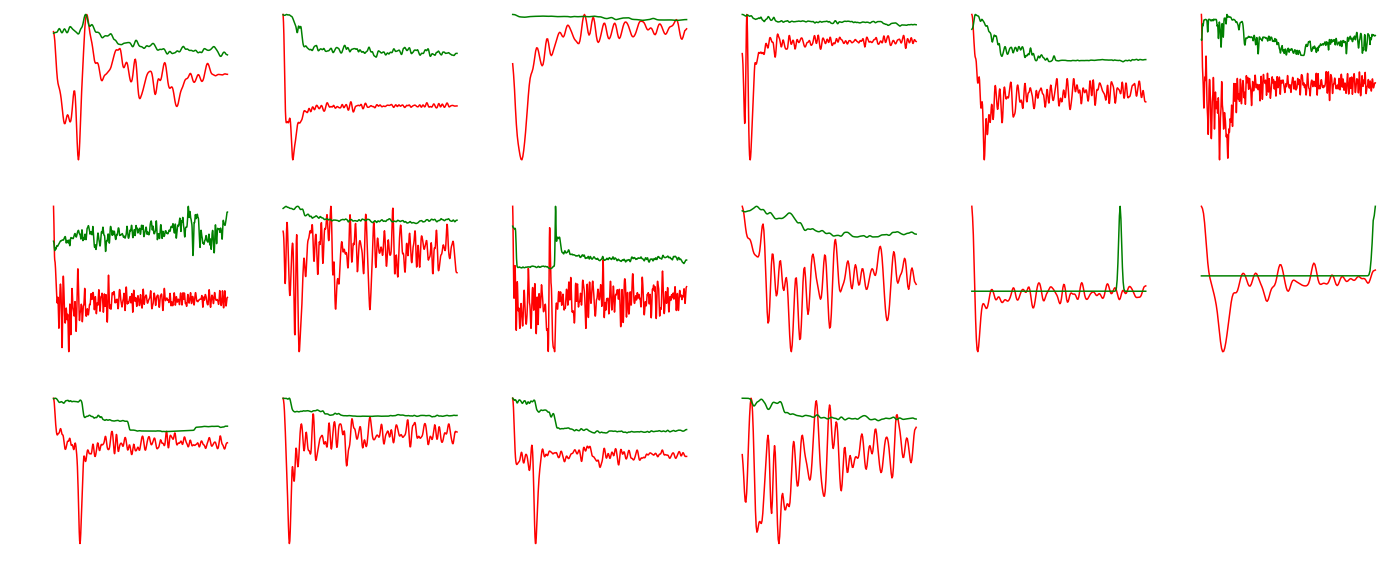

In [6]:
CLNcurves3 = []
for i in range(len(CLNcurves)):
    CLNcurves3.append(smooth(CLNcurves[i], 3))

CLNaIs3 = []
for i in range(len(CLNaIs)):
    CLNaIs3.append(smooth(CLNaIs[i], 3))
CLNdIs3 = derivatives(CLNtimesA, CLNaIs3)
CLNdIs33 = []
for i in range(len(CLNdIs3)):
    CLNdIs33.append(smooth(CLNdIs3[i], 3))

print(len(CLNtimesA), len(CLNaIs3), len(CLNdIs3), len(CLNdIs33))
CLNcurvesN = normalize(CLNcurves3)
CLNnucIsAN = normalize(CLNaIs)
CLNdIs33N = normalize(CLNdIs33)
print(len(CLNtimesA), len(CLNdIs33N), len(CLNtimesC), len(CLNcurvesN))

fig = plt.figure(figsize=[24,10])
for i in range(len(CLNnucIsAN)):
    fig.add_subplot(3,6,1+i)
    #plt.plot(CLNtimesA[i], CLNaIsN[i], color='red')
    plt.plot(CLNtimesA[i], CLNdIs33N[i], color='red')
    plt.plot(CLNtimesC[i], CLNcurvesN[i], color='green')
    plt.axis('off')

In [30]:
path = r'E:\YeastProject\JupyterOutput\NuclearEnvelope\Data'
times, spinPts, spinLs, spinLsC, arcLs, curves, RSs, neIAvg, neIMed, neIAvg0, neIMed0, pix, neAvgs, neSubAvgs = openFiles(path)
#imagesNEn = openIms(r'D:\YeastProject\InterVids\NuclearEnvelope\ReferenceCells\InterphaseNeighbors\Background')
#imagesNEm = openIms(r'D:\YeastProject\InterVids\NuclearEnvelope\ReferenceCells\InterphaseNeighbors\Background')

imagesBn = openIms(r'E:\YeastProject\InterVids\NuclearEnvelope\ReferenceCells\InterphaseNeighbors\Background')
imagesC = openIms(r'E:\YeastProject\InterVids\NuclearEnvelope\ReferenceCells\InterphaseNeighbors\Cytoplasm')
imagesN = openIms(r'E:\YeastProject\InterVids\NuclearEnvelope\ReferenceCells\InterphaseNeighbors\Nucleus')
startFramesN = [22,37, 22,33, 20,47, 19,18, 22,31,21,18,33, 20,23,21,20,35]
frameRatesN = [0.28]*len(startFramesN)
timesFitsN, cytoIs, nucIs, backIsN, backIsTN, CsN, cCs, nCs, Cn, cC, nC = fitCoefficientN(imagesC, imagesN, imagesBn, startFramesN, frameRatesN)
print(Cn, cC, nC)
cFits, nFits, cFitsInd, nFitsInd, cFs, nFs, cellCsN = testFitsN(timesFitsN, cytoIs, nucIs, backIsTN, CsN, cCs, nCs, Cn, cC, nC)
usefulN = [4,5, 6,7, 12,13, 15,16, 18,19,20,22,23, 26,27,28,29,30]
timesNEN, neIsN, fitIsN = fits(timesFitsN, neIAvg, cellCsN, usefulN)

imagesBm = openIms(r'E:\YeastProject\InterVids\NuclearEnvelope\ReferenceCells\MitoticNeighbors\Background')
imagesM = openIms(r'E:\YeastProject\InterVids\NuclearEnvelope\ReferenceCells\MitoticNeighbors\Mitotics')
startFramesM = [22,37, 20,47, 19,18,21, 22,18, 52,20,35]
frameRatesM = [0.28]*len(startFramesM)
timesFitsM, mitIs, backIsM, backIsTM, CsM, Cm = fitCoefficientM(imagesM, imagesBm, startFramesM, frameRatesM)
print(Cm)
mFits, mFitsInd = testFitsM(timesFitsM, mitIs, backIsTM, CsM, Cm)
usefulM = [4,5, 12,13, 15,16,17, 18,22, 25,26,30]
timesNEM, neIsM, fitIsM = fits(timesFitsM, neIAvg, CsM, usefulM)
timesM = []
curvesM = []
for n in range(len(curves)):
    if n in usefulM:
        time = []
        curve = []
        timesN = times[n]
        curvesN = curves[n]
        for i in range(len(curvesN)):
            if i != 0:
                time.append(timesN[i])
                curve.append(curvesN[i])
        timesM.append(time)
        curvesM.append(curve)

imagesB = openIms(r'E:\YeastProject\InterVids\NuclearEnvelope\NuclearSections\Background')
images = openIms(r'E:\YeastProject\InterVids\NuclearEnvelope\NuclearSections\Ablated')
imagesR = openIms(r'E:\YeastProject\InterVids\NuclearEnvelope\NuclearSections\Reference')
startFrames = [22,37, 18,21, 22, 20]
frameRates = [0.28]*len(startFrames)
nuclearIs = nuclearIntensities(images, startFrames)
timesFits, refIs, backIs, backIsT, Cs, C = fitCoefficientM(imagesR, imagesB, startFrames, frameRates)
print(C)
rFits, rFitsInd = testFitsM(timesFits, refIs, backIsT, Cs, C)
useful = [0,1,2,3,4,5]
timesNE, neIs, fitIs = fits(timesFits, nuclearIs, Cs, useful)
nuclearVidNs = [4,5, 16,17, 18, 26]
timesR = []
curvesR = []
for n in range(len(curves)):
    if n in nuclearVidNs:
        time = []
        curve = []
        timesN = times[n]
        curvesN = curves[n]
        for i in range(len(curvesN)):
            if i != 0:
                time.append(timesN[i])
                curve.append(curvesN[i])
        timesR.append(time)
        curvesR.append(curve)

0.025384121035388563 0.0235801893800619 0.029083099516458814
0.025837588965294332
0.028293653412331803


In [27]:
for n in range(len(curvesR)):
    print(len(timesNE[n]), len(curvesR[n]))

186 189
498 501
764 767
389 209
228 231
433 436


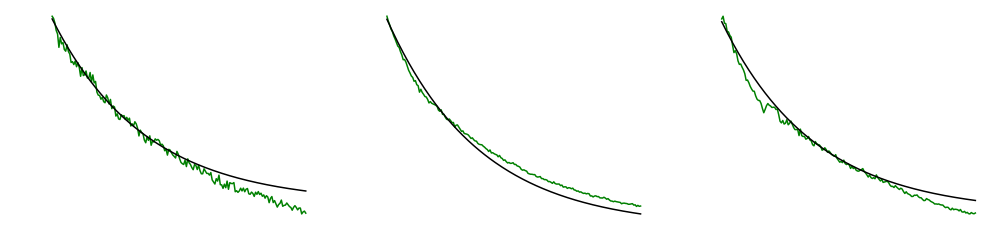

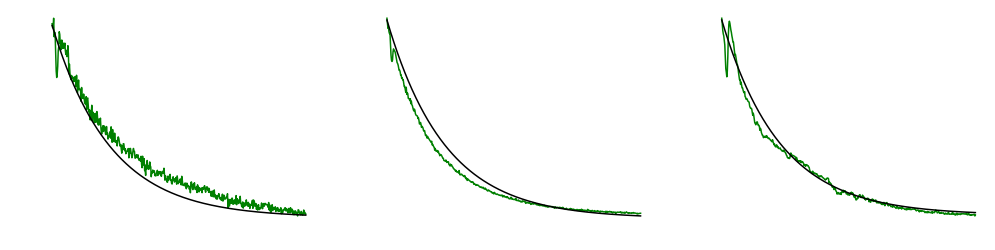

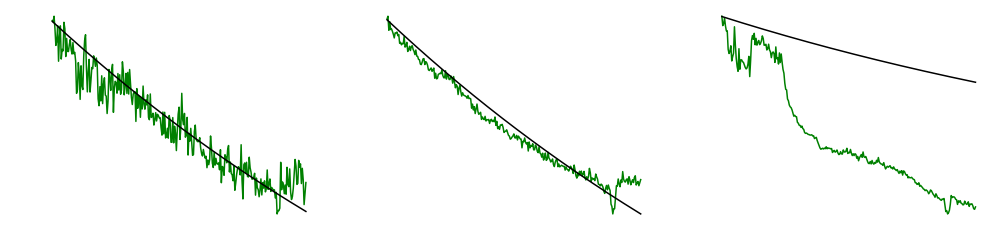

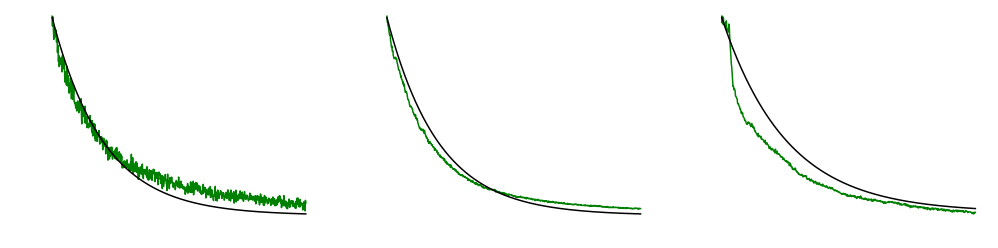

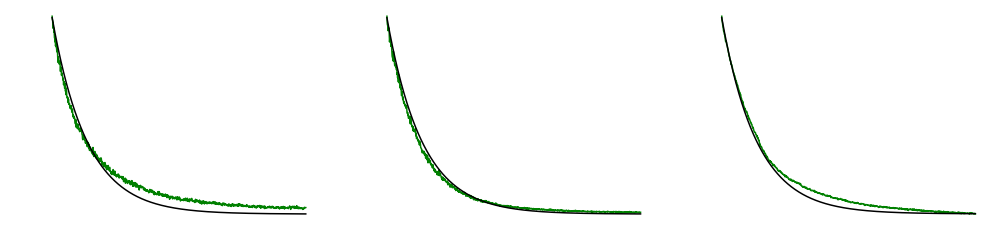

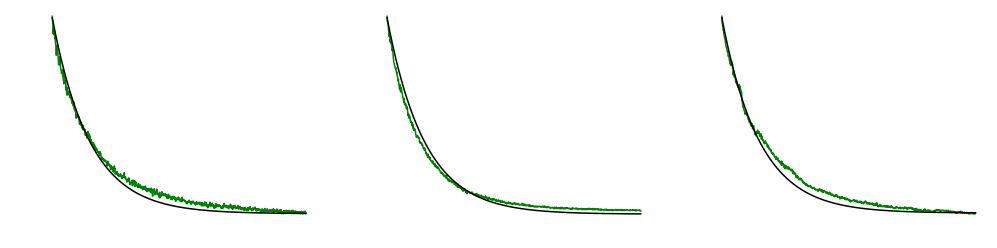

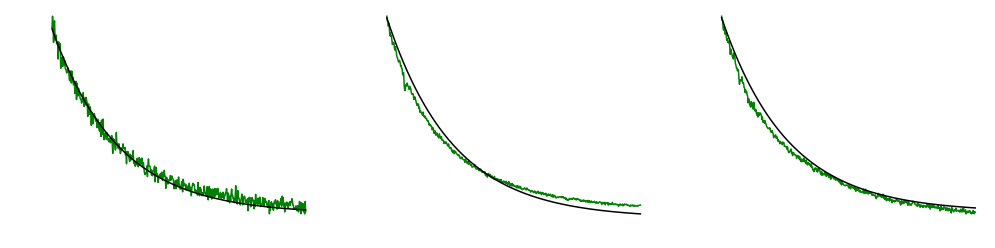

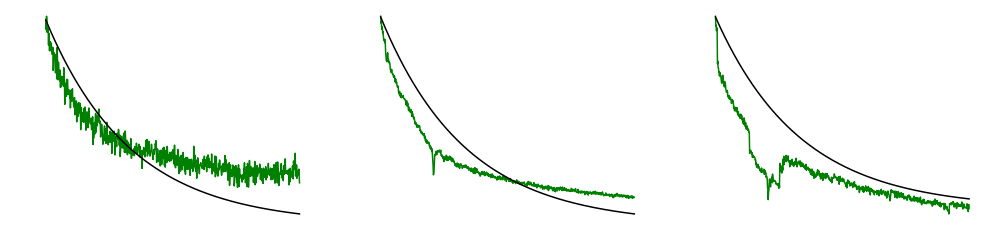

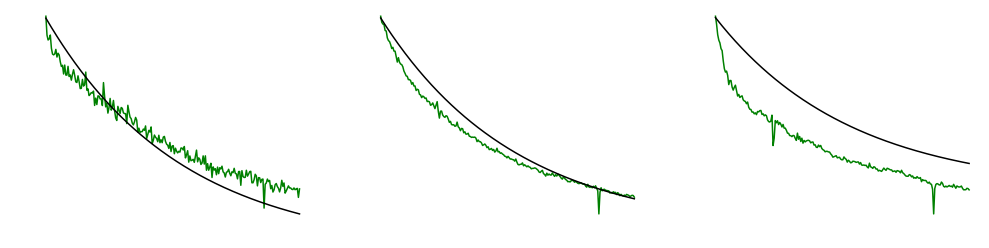

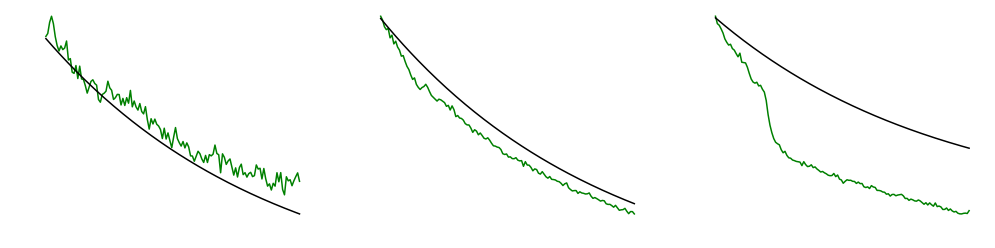

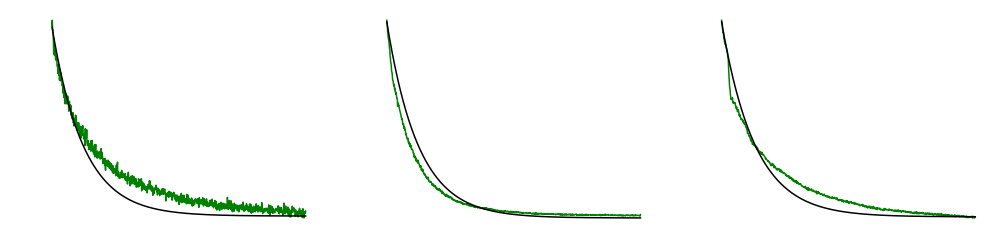

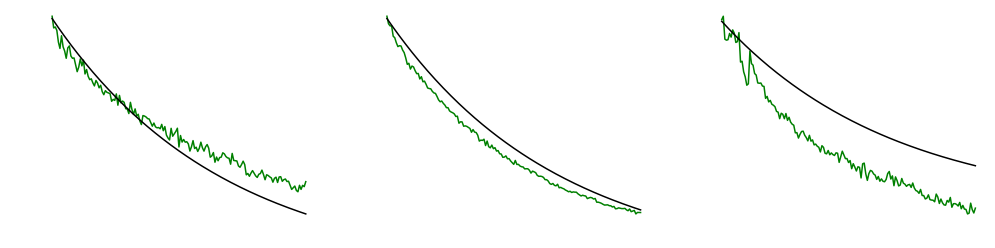

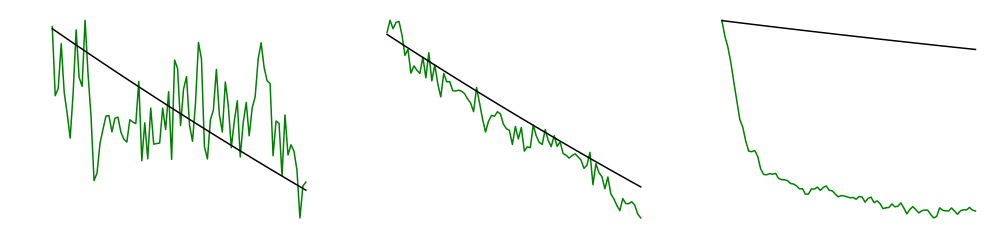

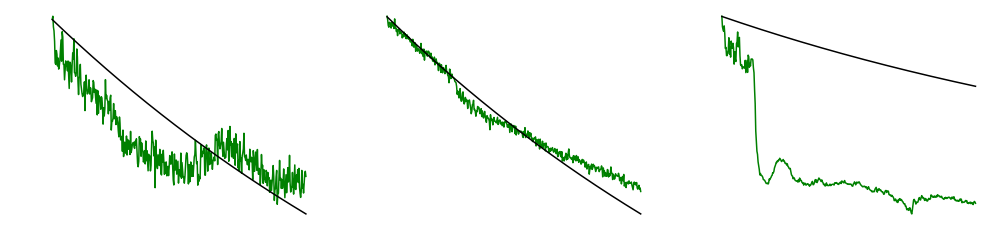

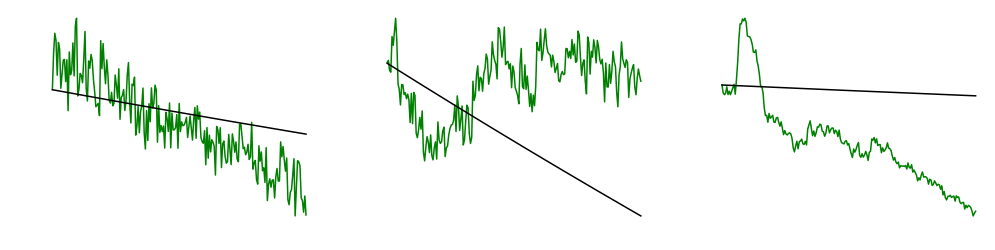

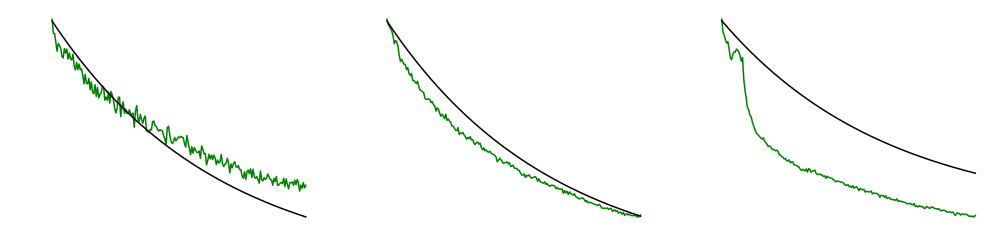

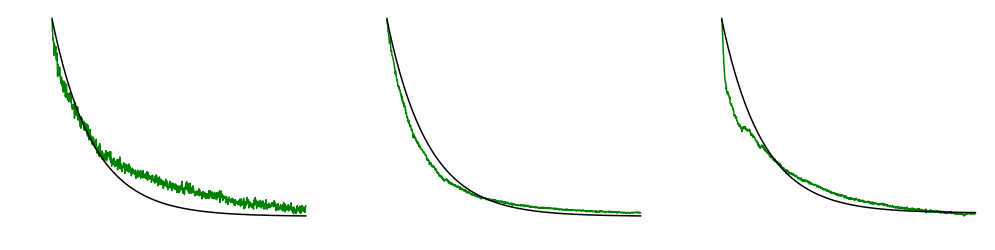

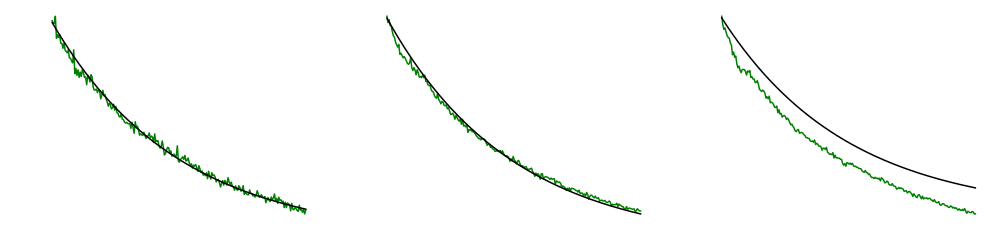

In [32]:
for i in range(len(cytoIs)):
    fig = plt.figure(figsize=[17,4])
    fig.add_subplot(1,3,1)
    plt.plot(timesFitsN[i], cytoIs[i], color='green')
    #plt.plot(timesFitsN[i], cFits[i], color='blue')
    #plt.plot(timesFitsN[i], cFitsInd[i], color='red')
    plt.plot(timesFitsN[i], cFs[i], color='black')
    plt.axis('off')
    fig.add_subplot(1,3,2)
    plt.plot(timesFitsN[i], nucIs[i], color='green')
    #plt.plot(timesFitsN[i], nFits[i], color='blue')
    #plt.plot(timesFitsN[i], nFitsInd[i], color='red')
    plt.plot(timesFitsN[i], nFs[i], color='black')
    plt.axis('off')
    fig.add_subplot(1,3,3)
    plt.plot(timesNEN[i], neIsN[i], color='green')
    #plt.plot(timesFitsN[i], nFits[i], color='blue')
    #plt.plot(timesFitsN[i], nFitsInd[i], color='red')
    plt.plot(timesNEN[i], fitIsN[i], color='black')
    plt.axis('off')

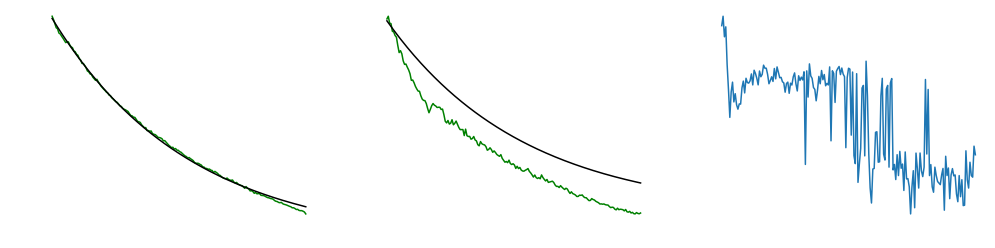

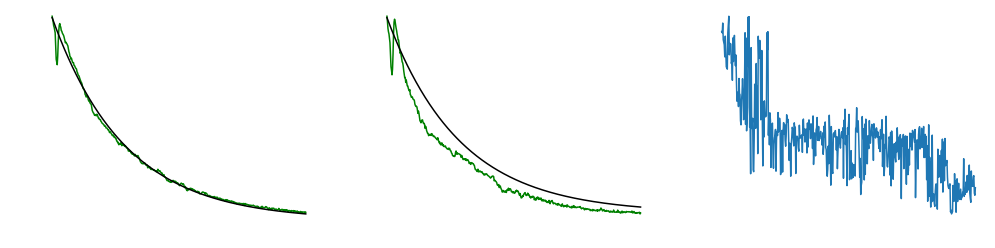

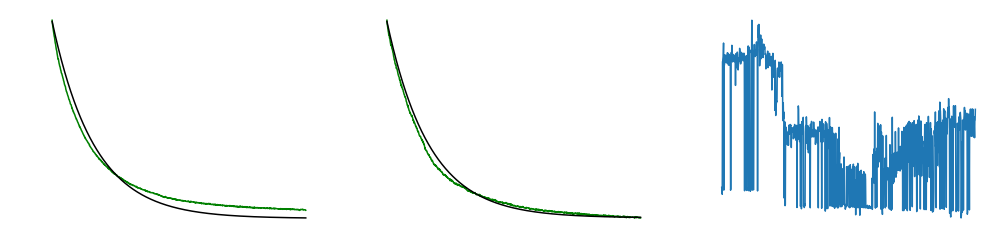

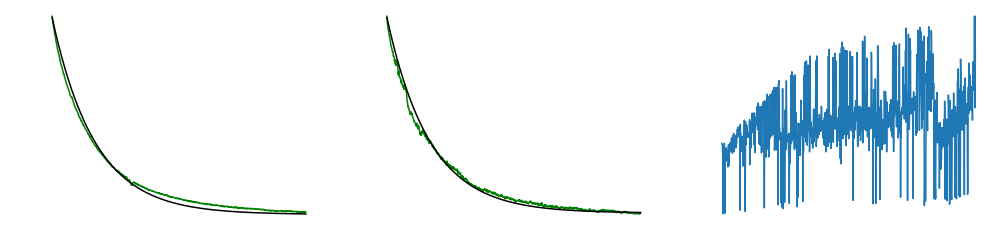

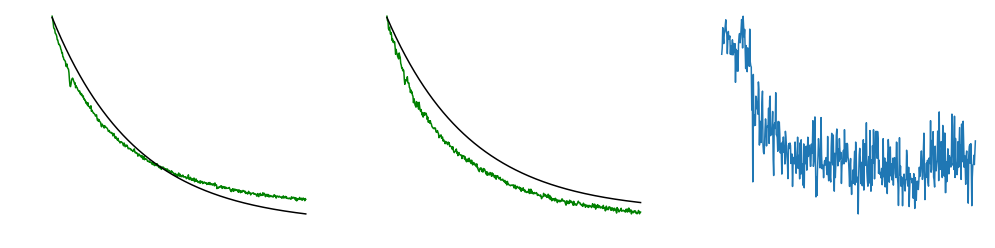

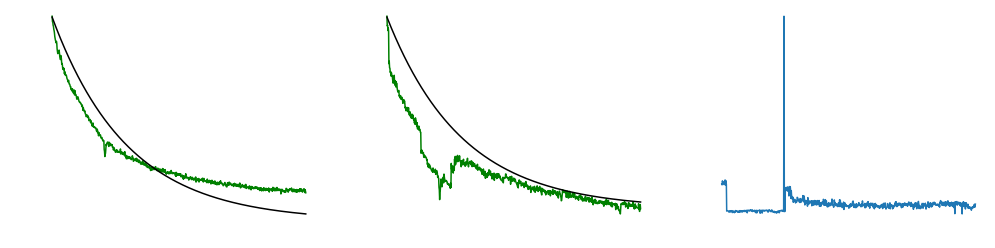

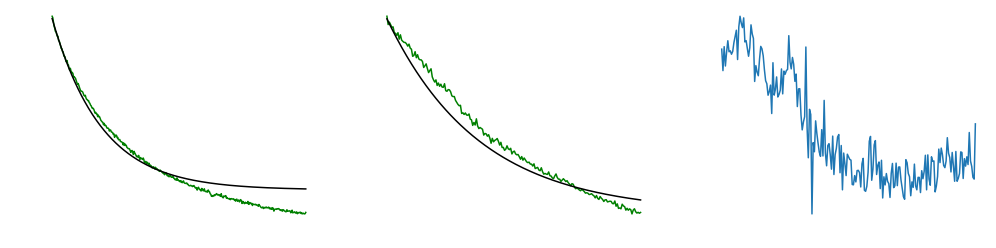

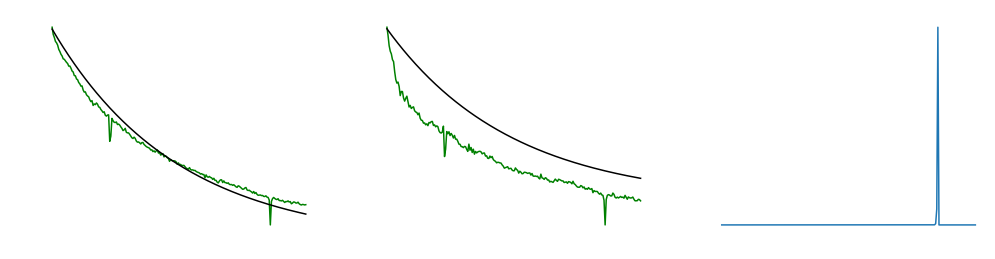

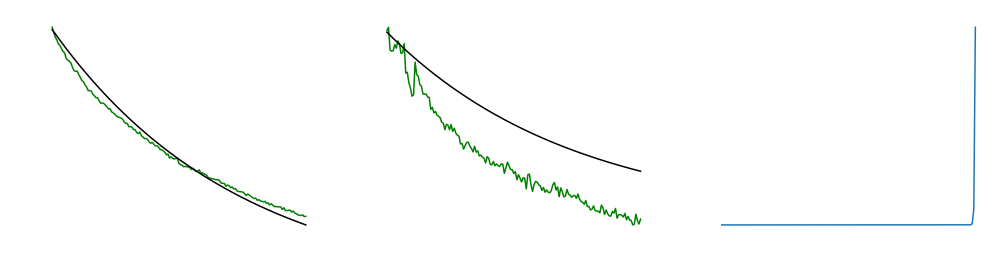

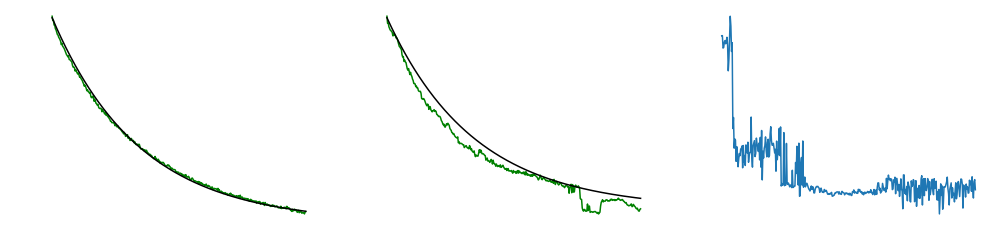

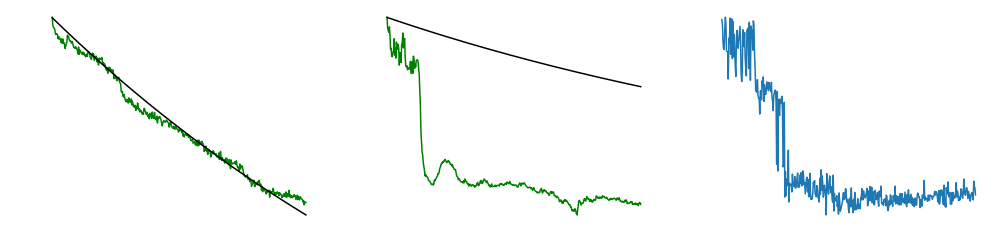

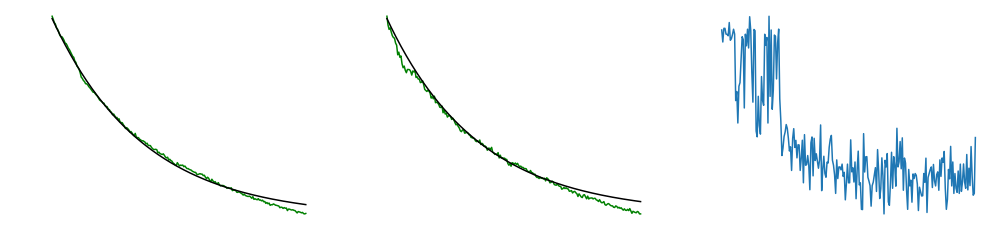

In [31]:
for i in range(len(mitIs)):
    fig = plt.figure(figsize=[17,4])
    fig.add_subplot(1,3,1)
    plt.plot(timesFitsM[i], mitIs[i], color='green')
    #plt.plot(timesFitsM[i], mFits[i], color='blue')
    #plt.plot(timesFitsM[i], mFitsInd[i], color='red')
    plt.plot(timesFitsM[i], mFitsInd[i], color='black')
    plt.axis('off')
    fig.add_subplot(1,3,2)
    plt.plot(timesNEM[i], neIsM[i], color='green')
    #plt.plot(timesFitsM[i], mFits[i], color='blue')
    #plt.plot(timesFitsM[i], mFitsInd[i], color='red')
    plt.plot(timesNEM[i], fitIsM[i], color='black')
    plt.axis('off')
    fig.add_subplot(1,3,3)
    plt.plot(timesM[i], curvesM[i])
    plt.axis('off')

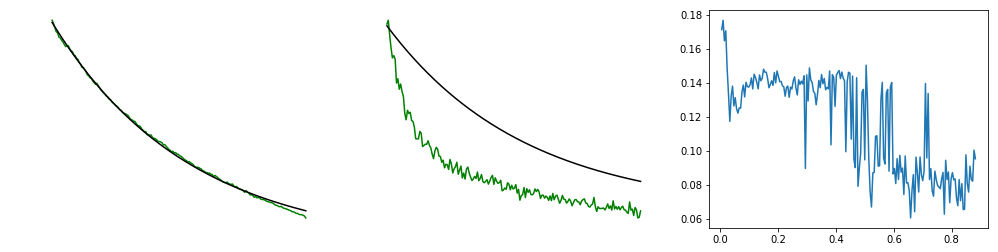

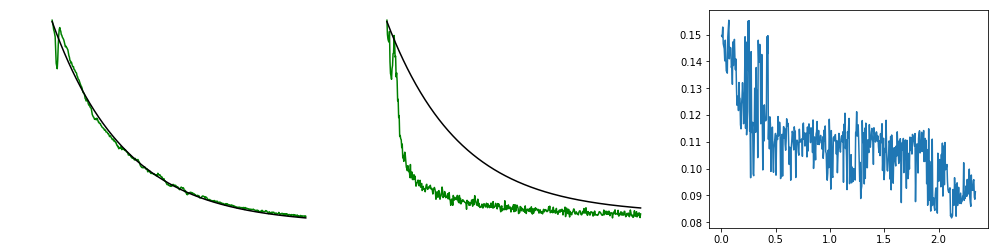

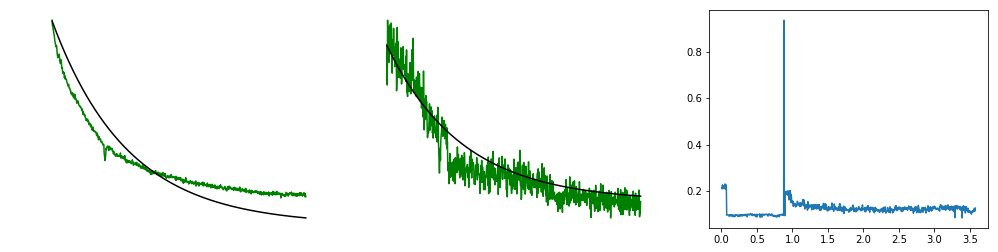

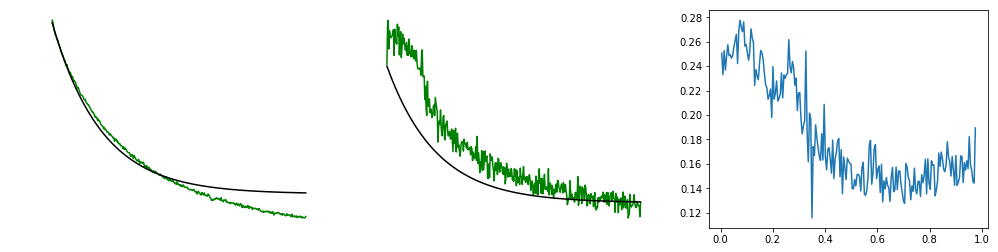

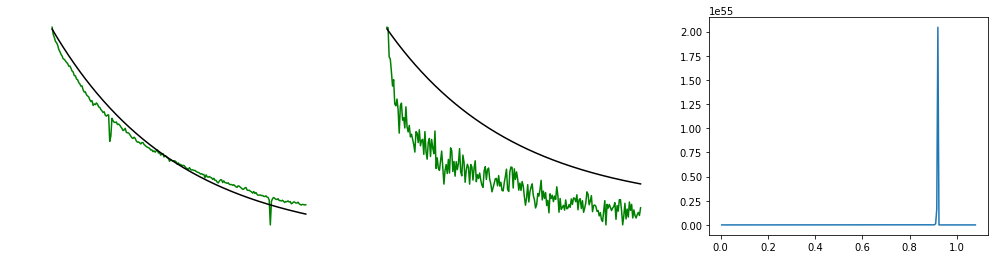

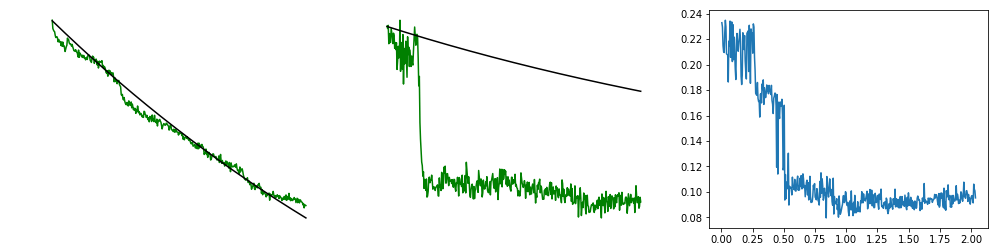

In [33]:
for i in range(len(refIs)):
    fig = plt.figure(figsize=[17,4])
    fig.add_subplot(1,3,1)
    plt.plot(timesFits[i], refIs[i], color='green')
    #plt.plot(timesFits[i], rFits[i], color='blue')
    #plt.plot(timesFits[i], rFitsInd[i], color='red')
    plt.plot(timesFits[i], rFitsInd[i], color='black')
    plt.axis('off')
    fig.add_subplot(1,3,2)
    plt.plot(timesNE[i], neIs[i], color='green')
    #plt.plot(timesFits[i], rFits[i], color='blue')
    #plt.plot(timesFits[i], rFitsInd[i], color='red')
    plt.plot(timesNE[i], fitIs[i], color='black')
    plt.axis('off')
    fig.add_subplot(1,3,3)
    plt.plot(timesR[i], curvesR[i])
    #plt.axis('off')

In [39]:
smoothCs = []
for i in range(len(curves)):
    smoothCsI, smoothRSsI = smoothCurve(curves[i], RSs[i], 3)
    smoothCs.append(smoothCsI)

fTs = []
for i in range(len(times)):
    fTsI = []
    for j in range(len(times[i])):
        fTsI.append(times[i][j]*60)
    fTs.append(fTsI)

fits, fitCs, fitCovs, taus, t0s = sigmoid(fTs, curves)
curveFitSkips = [6,8,9,13,18,22]
timesC = []
curvesC = []
smoothCsC = []
fitsC = []
tausC = []
t0sC = []
for i in range(len(times)):
    if i not in curveFitSkips:
        timesC.append(times[i])
        curvesC.append(curves[i])
        smoothCsC.append(smoothCs[i])
        fitsC.append(fits[i])
        tausC.append(taus[i])
        t0sC.append(t0s[i])

neIAvgN = []
for i in range(len(neAvgs)):
    neAvgNI = []
    for j in range(len(neAvgs[i])):
        neAvgNI.append(neIAvg[i][j]/neAvgs[i][j])
    neIAvgN.append(neAvgNI)
neFits, neFitCs, neFitCovs, neTaus, neT0s = sigmoid(fTs, neIAvg)

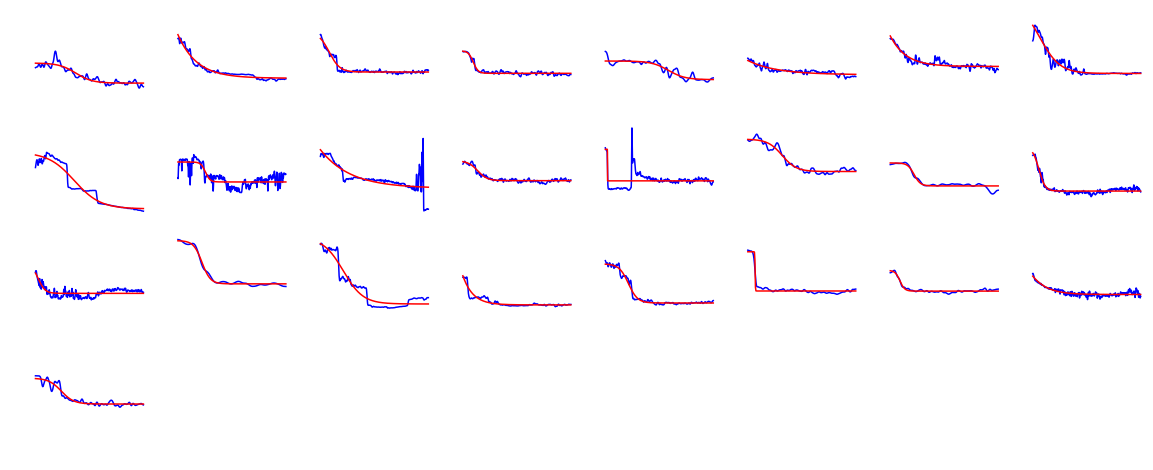

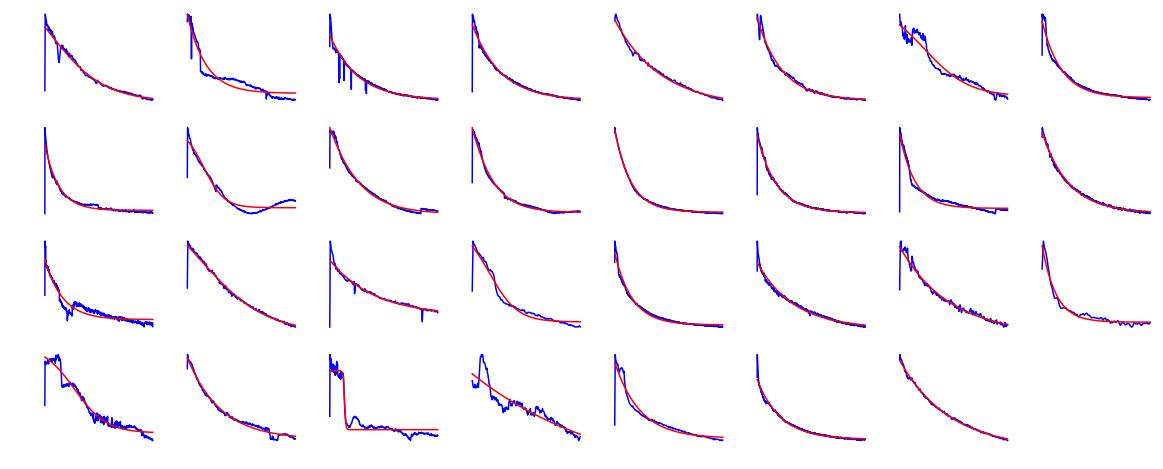

In [40]:
fig = plt.figure(figsize=[20,8])
for i in range(len(timesC)):
    fig.add_subplot(4,8,i+1)
    plt.plot(timesC[i], smoothCsC[i], '-b')
    plt.plot(timesC[i], fitsC[i], '-r')
    #plt.text(10, 0.25, str(i))
    #plt.xlim(0,250)
    plt.ylim(0,0.3)
    plt.axis('off')
    #plt.close()

fig = plt.figure(figsize=[20,8])
for i in range(len(times)):
    fig.add_subplot(4,8,i+1)
    plt.plot(times[i], neIAvg[i], '-b')
    plt.plot(times[i], neFits[i], '-r')
    plt.axis('off')
    #plt.text(10, 1.1, str(i))
    #plt.xlim(0,250)
    #plt.ylim(0,0.3)
    #plt.close()

([<matplotlib.axis.YTick at 0x1ef8de50da0>,
 <a list of 3 Text yticklabel objects>)

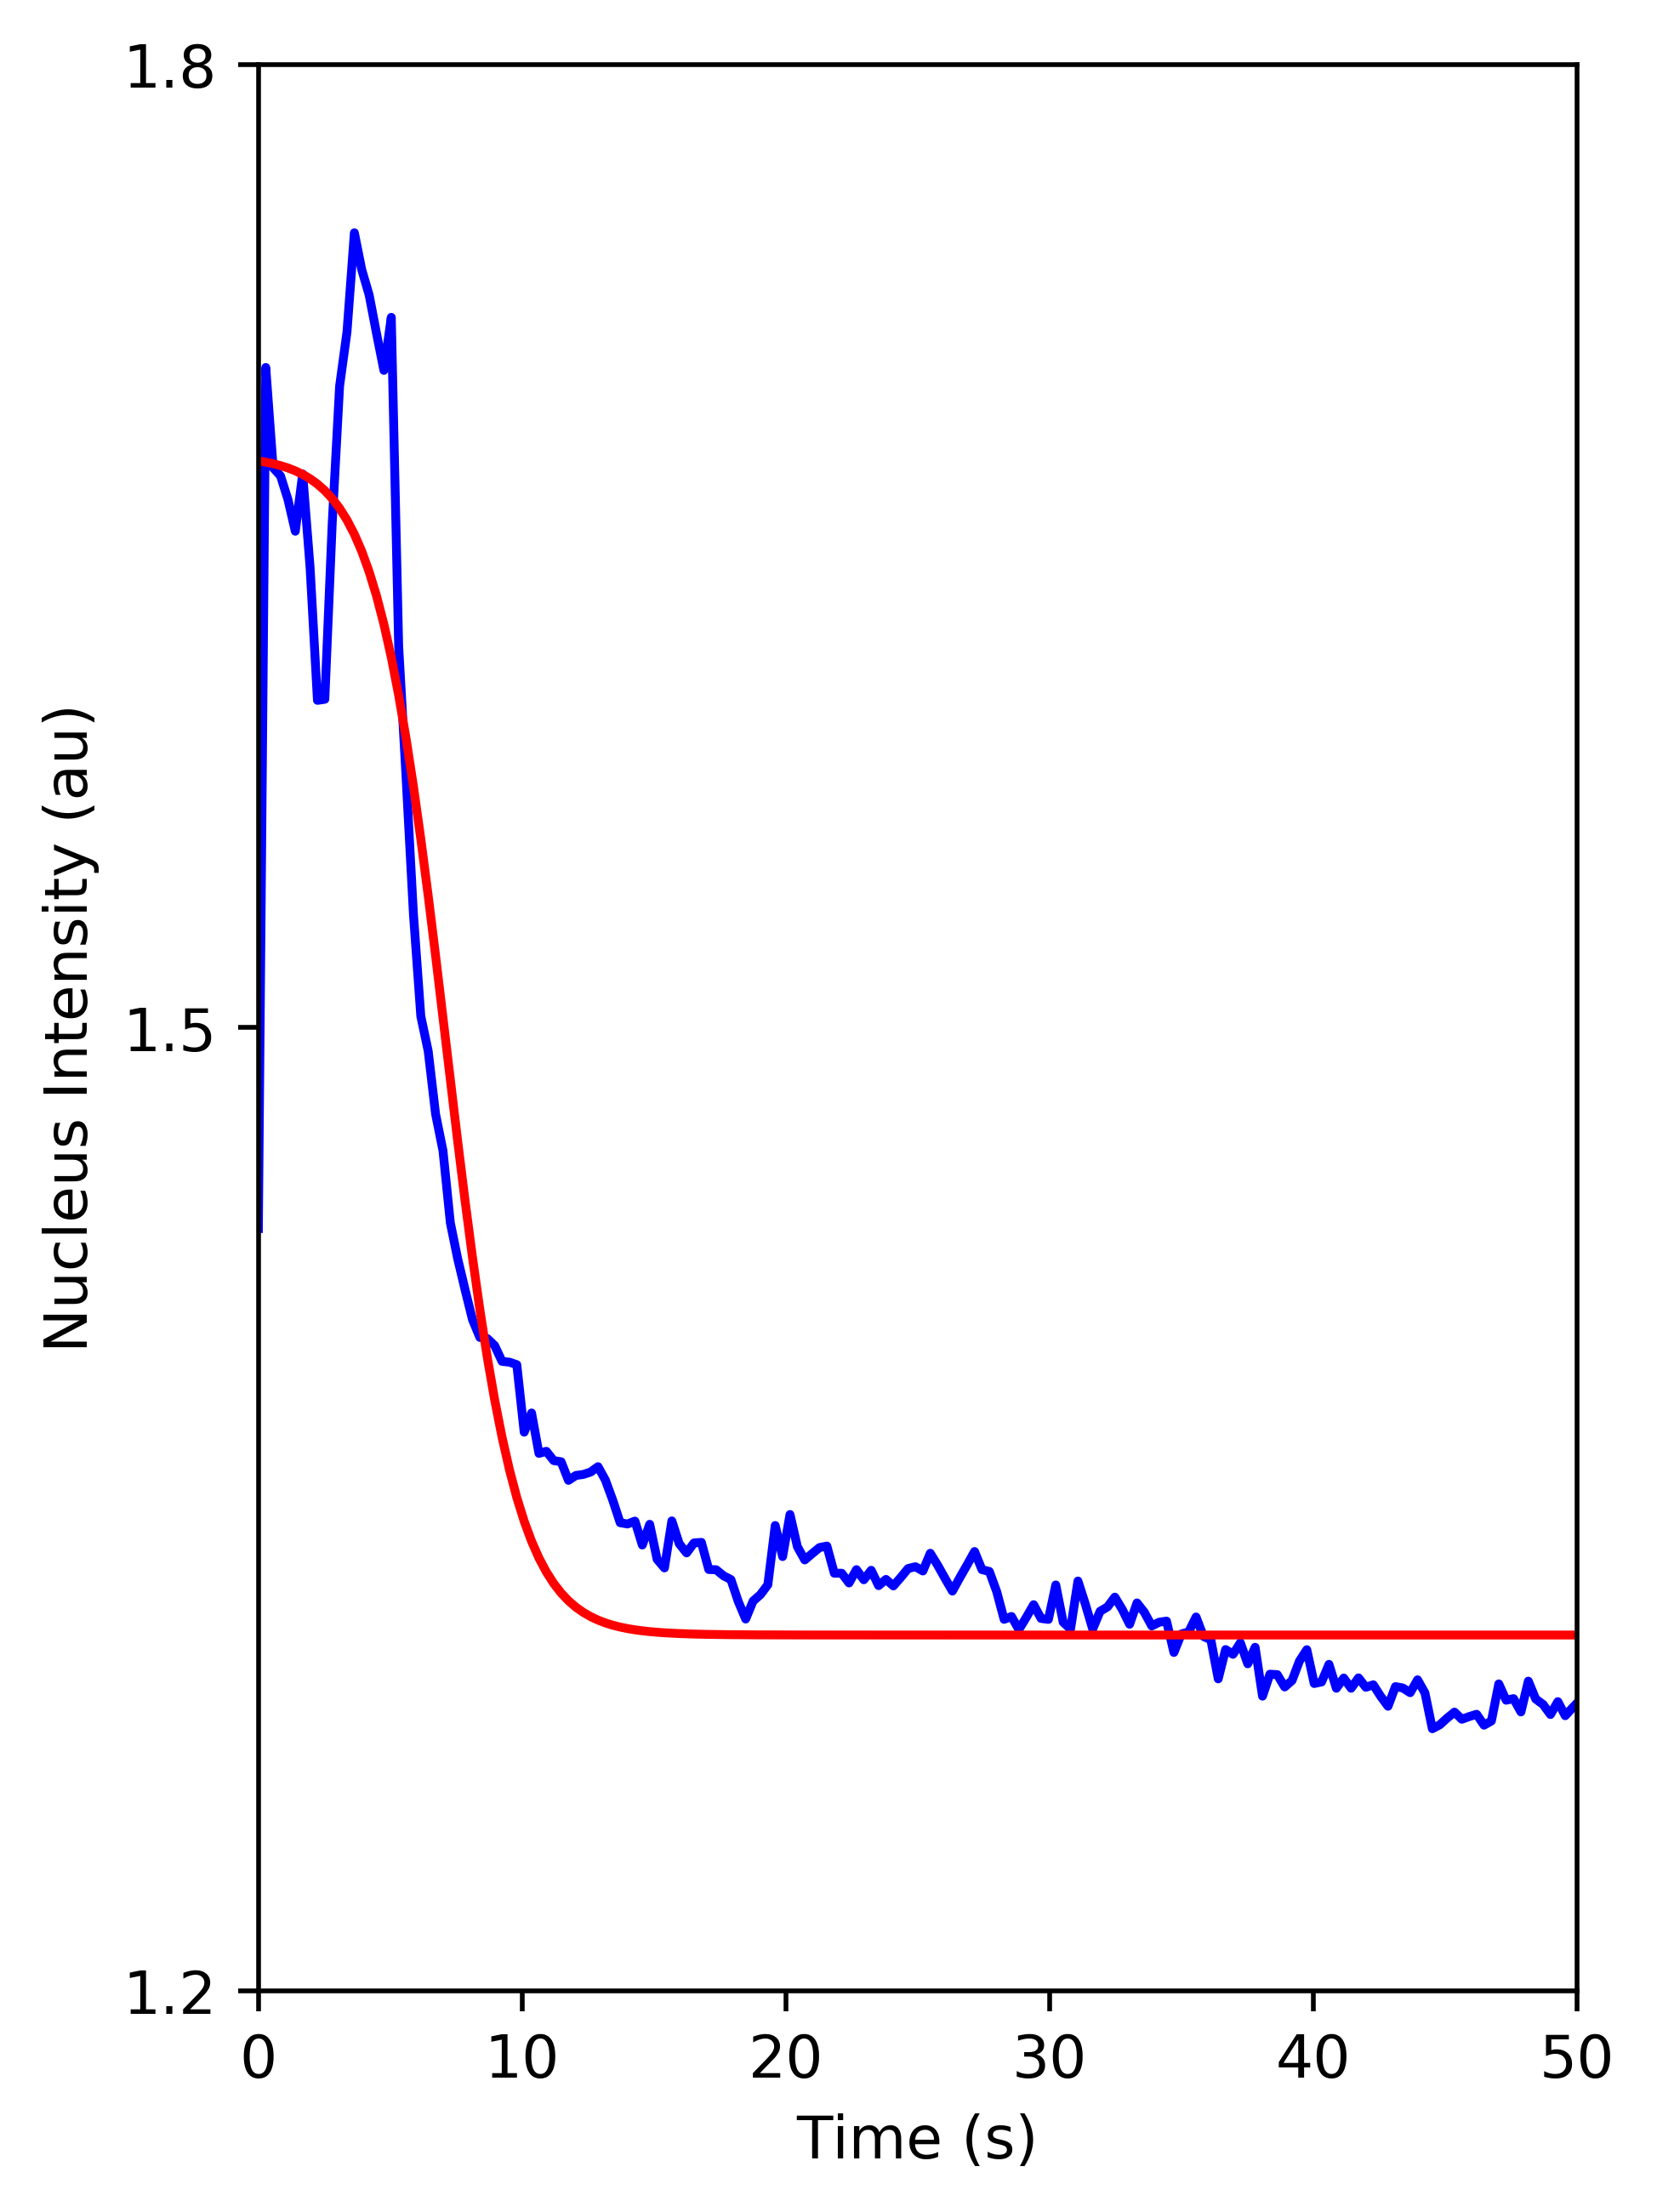

In [130]:
plt.figure(figsize=[4,6], dpi=500)
plt.plot(times[28], neIAvgN[28], '-b')
plt.plot(times[28], neFits[28], '-r')
plt.xlabel('Time (s)')
plt.ylabel('Nucleus Intensity (au)')
plt.xlim(0,50)
plt.ylim(1.2,1.8)
plt.yticks([1.2,1.5,1.8])

In [62]:
curveFitSkips = [6,8,9,13,18,22]
timesC = []
curvesC = []
fitsC = []
for i in range(len(times)):
    if i not in curveFitSkips:
        timesC.append(times[i])
        curvesC.append(curves[i])
        fitsC.append(fits[i])

Text(0, 0.5, 'Tau 1 (1/s)')

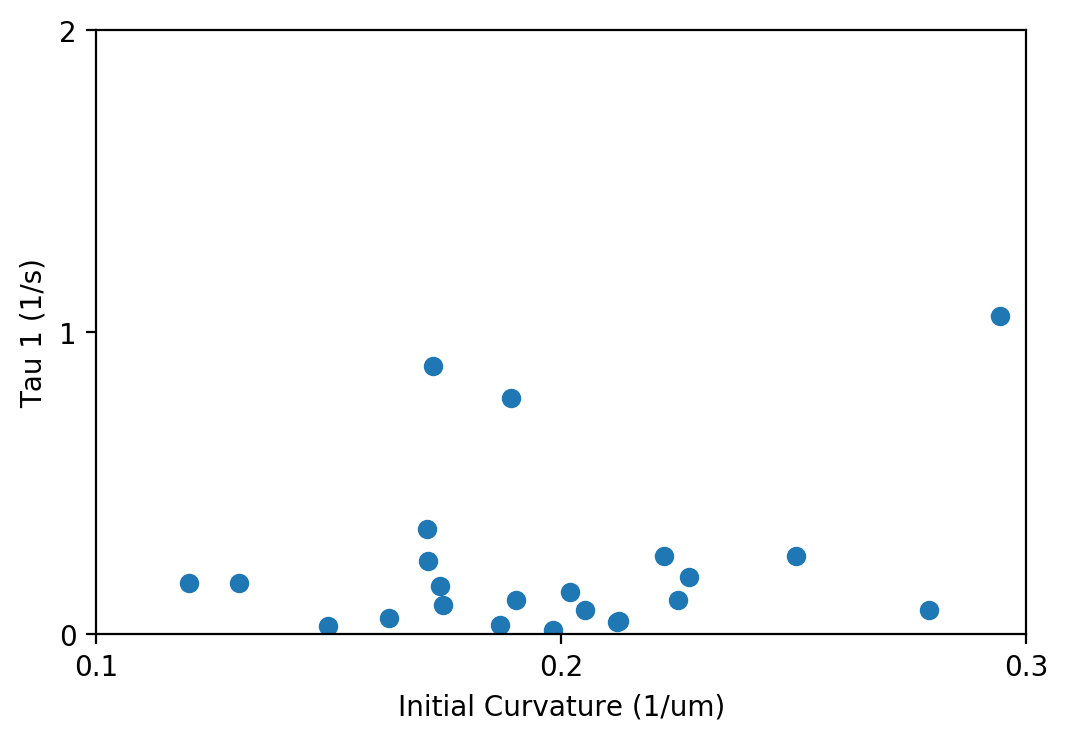

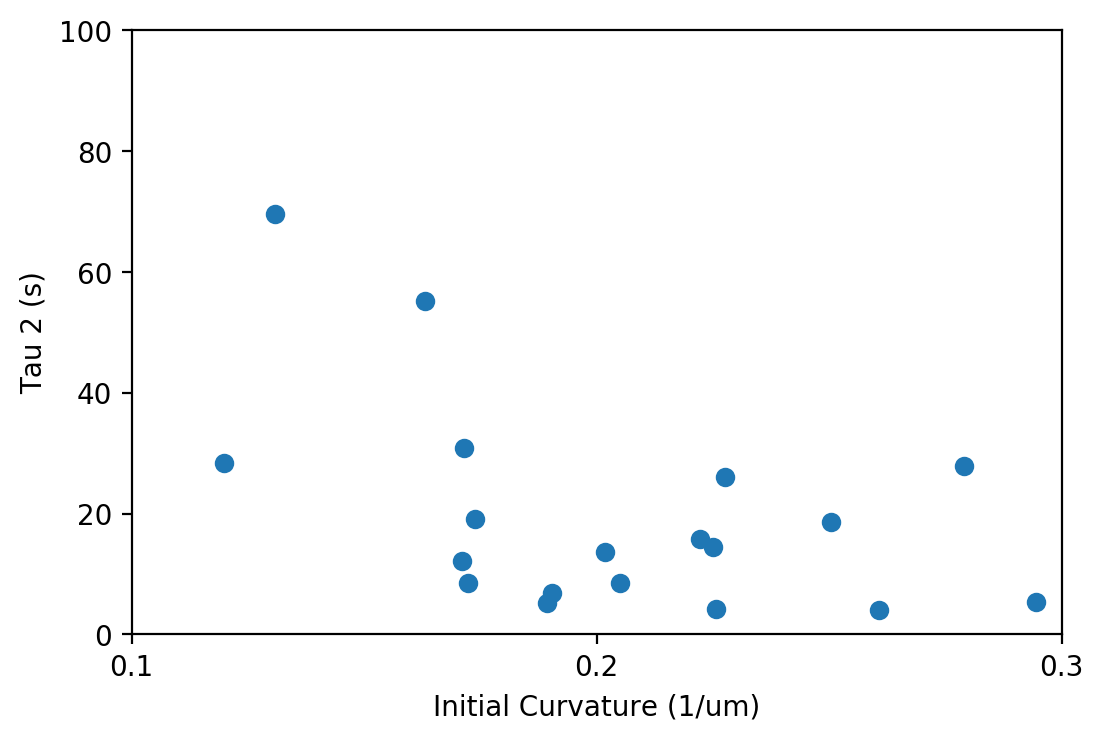

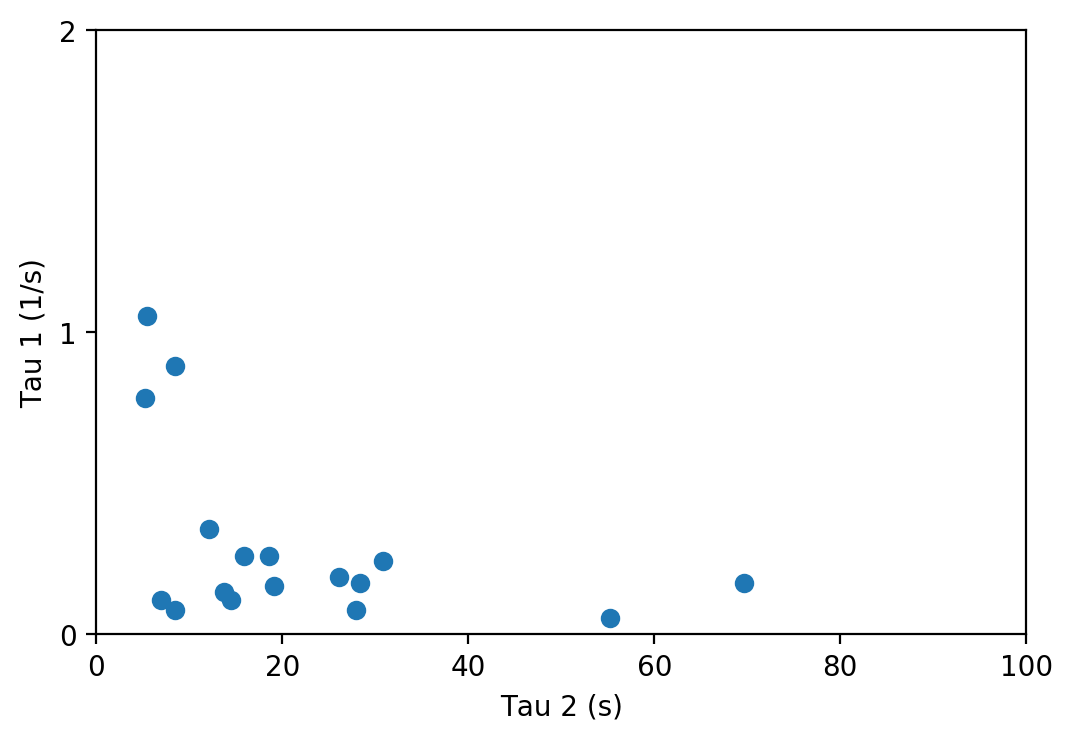

In [111]:
curve0s = []
for i in range(len(curvesC)):
    #curve0s.append(np.amax(smoothCs[i]))
    curve0s.append(curvesC[i][0])

plt.figure(dpi=200)
plt.scatter(curve0s, tausC)
plt.xlim(0.1,0.3)
plt.ylim(0,2)
plt.xticks([0.1,0.2,0.3])
plt.yticks([0,1,2])
plt.xlabel('Initial Curvature (1/um)')
plt.ylabel('Tau 1 (1/s)')

plt.figure(dpi=200)
plt.scatter(curve0s, t0sC)
plt.xlim(0.1,0.3)
plt.ylim(0,100)
plt.xticks([0.1,0.2,0.3])
#plt.yticks([0,1,2])
plt.xlabel('Initial Curvature (1/um)')
plt.ylabel('Tau 2 (s)')

plt.figure(dpi=200)
plt.scatter(t0sC, tausC)
plt.xlim(0,100)
plt.ylim(0,2)
#plt.xticks([0.1,0.2,0.3])
plt.yticks([0,1,2])
plt.xlabel('Tau 2 (s)')
plt.ylabel('Tau 1 (1/s)')